# Studienarbeit Data Exploration

## Laden einiger wichtiger Bibliotheken

In [1]:
import requests
import random
import warnings
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tabulate import tabulate
from typing import List, Tuple
from collections import Counter
from sklearn.metrics import confusion_matrix
from datasets import Dataset, DatasetDict, concatenate_datasets
from collections import Counter
from matplotlib import cm
from transformers import (
    DistilBertTokenizerFast,
    AutoTokenizer, 
    AutoConfig,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments
)
from adapters import AutoAdapterModel
from adapters import AdapterTrainer, AdapterConfig
from adapters import init
from adapters.composition import Stack


# 1.) Laden der Daten


In [2]:
#Statische Variablen
SETH_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/SETH-train.iob'
SETH_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/SETH-test.iob'

VARIOME_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome-train.iob'
VARIOME_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome-test.iob'

VARIOME120_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome120-train.iob'
VARIOME120_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/Variome120-test.iob'

AMIA_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/amia-train.iob'
AMIA_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/amia-test.iob'

TMVAR_TRAIN_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/tmvar-train.iob'
TMVAR_TEST_URL = 'https://raw.githubusercontent.com/Erechtheus/mutationCorpora/master/corpora/IOB/tmvar-test.iob'

# Funktion, um die Daten von von Github herunterzuladen
def download_data(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # Überprüfen, ob die Anfrage erfolgreich war
    with open(filename, 'w') as file:
        file.write(response.text)

# Herunterladen der Daten
download_data(SETH_TRAIN_URL, 'SETH-train.iob')
download_data(SETH_TEST_URL, 'SETH-test.iob')

download_data(VARIOME_TRAIN_URL, 'Variome-train.iob')
download_data(VARIOME_TEST_URL, 'Variome-test.iob')

download_data(VARIOME120_TRAIN_URL, 'Variome120-train.iob')
download_data(VARIOME120_TEST_URL, 'Variome120-test.iob')

download_data(AMIA_TRAIN_URL, 'amia-train.iob')
download_data(AMIA_TEST_URL, 'amia-test.iob')

download_data(TMVAR_TRAIN_URL, 'tmvar-train.iob')
download_data(TMVAR_TEST_URL, 'tmvar-test.iob')

# Funktion zum parsen der heruntergeladenen Daten
def read_data_with_sentences(filename):
    documents = []
    current_document = []
    current_sentence = []
    
    with open(filename, 'r') as file:
        next(file)  # Ignoriere die erste Zeile (Spaltenüberschriften)
        for line in file:
            line = line.strip()

            # Überspringe header oder leere Zeilen
            if not line or line == "Word,Tag" or line == ",O":
                continue
            
            # Prüfe, ob es eine Dokumenten-ID ist (beginnt mit "#" und hat kein "," bzw. Zeile != "#,O")
            if line.startswith("#") and "," not in line:  
                if current_document:  # Speichere aktuelles Dokument sofern vorhanden
                    documents.append(current_document)
                current_document = []  # Neues Dokument wird gestartet

            # Prüfe, ob es sich um das Satzende handelt.
            elif line == ",":  
                if current_sentence:  # Speichere aktuellen Satz sofern vorhanden
                    current_document.append(current_sentence)
                current_sentence = []  # Neuer Satz wird gestartet
            
            # Token und Label verarbeiten
            elif line:  
                try:
                    # Trenne Token und Label anhand des letzten Kommas (rsplit)
                    # Kann auch mehrere komma geben (z.B. ",,O")
                    token, label = line.rsplit(",", 1)
                    current_sentence.append((token, label))
                except ValueError:
                    print(f"Zeile konnte nicht verarbeitet werden: {line}")
        
        # Letzten Satz und Dokument speichern
        if current_sentence:  # Letzter Satz
            current_document.append(current_sentence)
        if current_document:  # Letztes Dokument
            documents.append(current_document)
    
    return documents

# 2.) Experiment vorbereiten


In [3]:
# Funktion zum Zählen von Sätzen und Entitäten
def count_sentences_and_entities(title, documents: List[List[List[Tuple[str, str]]]]) -> Tuple[int, int]:
    sentence_count = 0
    entity_count = 0
    
    for doc in documents:
        for sentence in doc:
            sentence_count += 1
            in_entity = False  # Status, ob wir in einer Entität sind
            
            """
            Hier hab ich 2 Möglichkeiten gesehen wie man Entitäten zählen kann
            1. Anzahl der Klassen != O
            2. B-* und I-* Tags zu einer Entität zusammenzählen

            Habe mich für den 2. Weg entscheiden, da sich dies realitätsnaher anfühlte
            """
            for _, label in sentence:
                if label.startswith("B-"):  # Beginn einer neuen Entität
                    entity_count += 1
                    in_entity = True  # Wir sind jetzt in einer Entität
                elif label.startswith("I-"):  # Innerhalb einer Entität
                    if not in_entity:  # Wenn kein "B-" Tag vorher war, ignorieren
                        continue
                else:
                    in_entity = False  # Nicht mehr in einer Entität
    
    print(f"{title}: {len(documents)} Dokumente, {sentence_count} Sätze, {entity_count} Entitäten")




In [4]:
datasets = [
    {"name": "SETH", "train": read_data_with_sentences("SETH-train.iob"), "test": read_data_with_sentences("SETH-test.iob")},
    {"name": "Variome", "train": read_data_with_sentences("Variome-train.iob"), "test": read_data_with_sentences("Variome-test.iob")},
    {"name": "Variome120", "train": read_data_with_sentences("Variome120-train.iob"), "test": read_data_with_sentences("Variome120-test.iob")},
    {"name": "Amia", "train": read_data_with_sentences("amia-train.iob"), "test": read_data_with_sentences("amia-test.iob")},
    {"name": "TmVar", "train": read_data_with_sentences("tmvar-train.iob"), "test": read_data_with_sentences("tmvar-test.iob")},
]

# Iteriere über die Datensätze und gebe Anzahl Sätze und Entities aus
for dataset in datasets:
    count_sentences_and_entities(
        title=f"{dataset['name']} Trainingsdaten", 
        documents=dataset["train"]
    )
    count_sentences_and_entities(
        title=f"{dataset['name']} Testdaten", 
        documents=dataset["test"]
    )

SETH Trainingsdaten: 504 Dokumente, 4007 Sätze, 2674 Entitäten
SETH Testdaten: 126 Dokumente, 951 Sätze, 543 Entitäten
Variome Trainingsdaten: 96 Dokumente, 1580 Sätze, 5125 Entitäten
Variome Testdaten: 24 Dokumente, 372 Sätze, 971 Entitäten
Variome120 Trainingsdaten: 96 Dokumente, 1580 Sätze, 87 Entitäten
Variome120 Testdaten: 24 Dokumente, 372 Sätze, 29 Entitäten
Amia Trainingsdaten: 100 Dokumente, 1082 Sätze, 1787 Entitäten
Amia Testdaten: 45 Dokumente, 500 Sätze, 752 Entitäten
TmVar Trainingsdaten: 334 Dokumente, 4067 Sätze, 982 Entitäten
TmVar Testdaten: 166 Dokumente, 1942 Sätze, 469 Entitäten


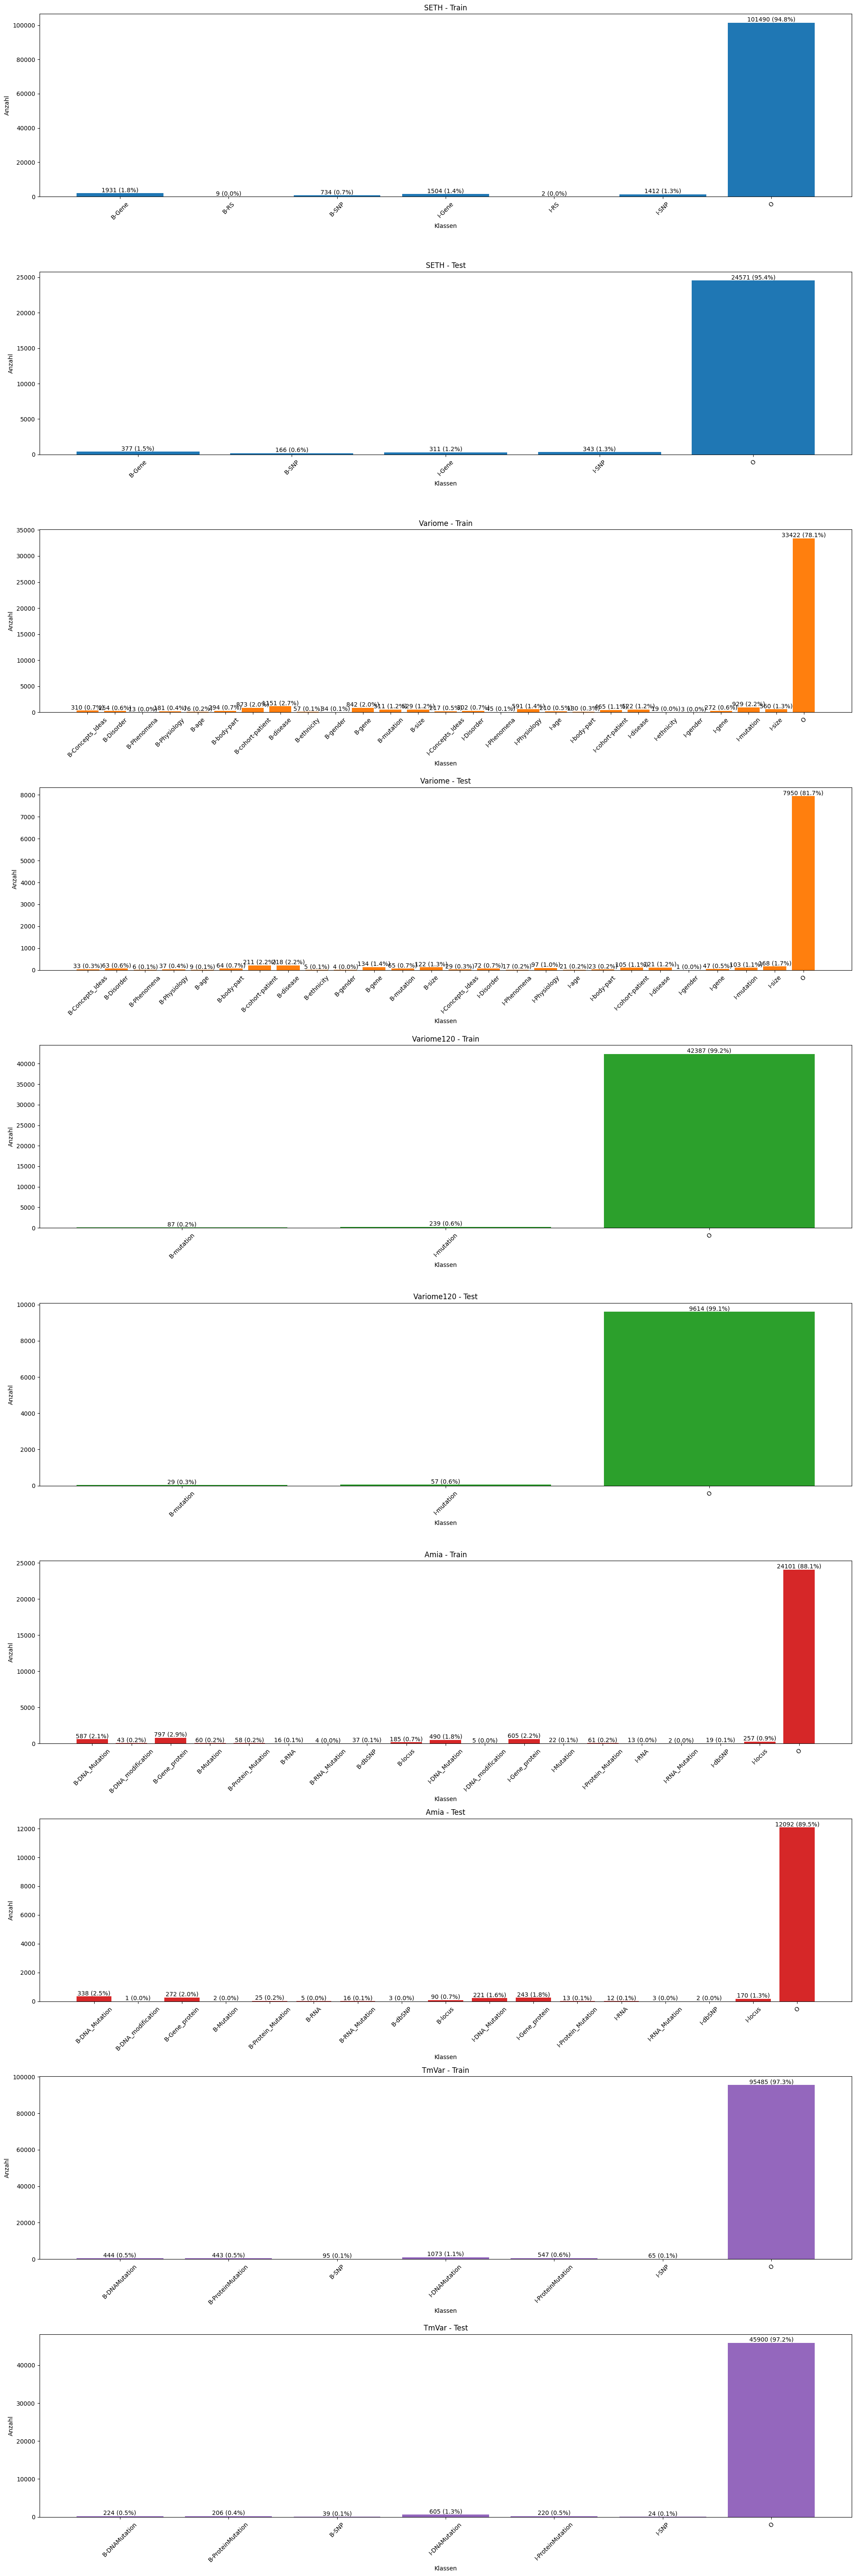

In [5]:
# Zähle und plotte die Klassenverteilung
def count_and_plot_classes(documents: List[List[List[Tuple[str, str]]]], ax, all_classes=None, color=None) -> None:
    labels = []
    for doc in documents:
        for sentence in doc:
            labels.extend(label for _, label in sentence)
    
    # Berechne die Klassenverteilung
    class_distribution = Counter(labels)
    
    # Falls `all_classes` nicht angegeben ist, ermitteln wir sie dynamisch
    if all_classes is None:
        all_classes = sorted(class_distribution.keys())  # Alphabetisch sortieren
    
    # Stelle sicher, dass alle gewünschten Klassen angezeigt werden (auch wenn sie nicht im aktuellen Datensatz vorkommen)
    for cls in all_classes:
        if cls not in class_distribution:
            class_distribution[cls] = 0  # Füge fehlende Klassen mit 0 hinzu
    
    # Sortiere die Klassen nach `all_classes`
    ordered_keys = all_classes
    ordered_values = [class_distribution[cls] for cls in ordered_keys]

    # Plot der Klassenverteilung
    bars = ax.bar(ordered_keys, ordered_values, color=color)
    
    # Absolute und prozentuale Werte hinzufügen
    total_count = sum(class_distribution.values())
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height} ({height / total_count * 100:.1f}%)', 
                     xy=(bar.get_x() + bar.get_width() / 2, height), 
                     ha='center', va='bottom')
    
    ax.set_xlabel('Klassen')
    ax.set_ylabel('Anzahl')




# Farben für die Datensätze aus einer Farbpalette
colors = cm.tab10(range(len(datasets)))  # Unterschiedliche Farben für die Datensätze

# Diagramm für alle Datensätze
fig, axs = plt.subplots(len(datasets) * 2, 1, figsize=(20, 6 * len(datasets) * 2))  # Eine Zeile pro Diagramm

for i, (dataset, color) in enumerate(zip(datasets, colors)):
    # Train split
    count_and_plot_classes(dataset["train"], axs[i * 2], color=color)
    axs[i * 2].set_title(f'{dataset["name"]} - Train')
    axs[i * 2].tick_params(axis='x', rotation=45)  # Drehe die x-Beschriftungen
    
    # Test split
    count_and_plot_classes(dataset["test"], axs[i * 2 + 1], color=color)
    axs[i * 2 + 1].set_title(f'{dataset["name"]} - Test')
    axs[i * 2 + 1].tick_params(axis='x', rotation=45)  # Drehe die x-Beschriftungen

plt.tight_layout()
plt.show()


In [6]:
# Funktion zur Aufteilung in Train/Dev
def split_documents(documents, train_ratio=0.8):
    random.shuffle(documents)  # Zufällige Reihenfolge der Dokumente
    split_index = int(len(documents) * train_ratio)
    train_split = documents[:split_index]
    dev_split = documents[split_index:]
    return train_split, dev_split

# Aktualisiere die Datasets-Liste mit Train/Dev-Splits
split_datasets = []

for data in datasets:
    print(f"Erzeuge Train/Dev-Split für {data['name']}...")
    
    # Train/Dev-Split durchführen
    train_split, dev_split = split_documents(data['train'], train_ratio=0.8)
    
    # Ergebnisse speichern
    split_datasets.append({
        "name": data["name"],
        "train": train_split,
        "dev": dev_split,
        "test": data["test"]
    })

Erzeuge Train/Dev-Split für SETH...
Erzeuge Train/Dev-Split für Variome...
Erzeuge Train/Dev-Split für Variome120...
Erzeuge Train/Dev-Split für Amia...
Erzeuge Train/Dev-Split für TmVar...


In [7]:
# Brauchen gemappte Labels, sonst zu wenig Überschneidung:
UNIFIED_LABELS = [
    "O",
    "B-Gene/Protein", "I-Gene/Protein",
    "B-SNP", "I-SNP",
    "B-Mutation", "I-Mutation",
    "B-DNA_Mutation", "I-DNA_Mutation",
    "B-RNA_Mutation", "I-RNA_Mutation",
    "B-Protein_Mutation", "I-Protein_Mutation",
    "B-Disease/Disorder", "I-Disease/Disorder",
    "B-Patient_Attribute", "I-Patient_Attribute",
    "B-Phenomena/Concepts", "I-Phenomena/Concepts",
    "B-Locus", "I-Locus",
    "B-Measurement", "I-Measurement",
    "B-Ethnicity", "I-Ethnicity",
]



LABEL_MAPPING = {
    "SETH": {
        "O": "O",
        "B-Gene": "B-Gene/Protein",
        "I-Gene": "I-Gene/Protein",
        "B-RS": "O",
        "I-RS": "O",
        "B-SNP": "B-SNP",
        "I-SNP": "I-SNP"
    },
    "Variome": {
        "O": "O",
        "B-Concepts_Ideas": "B-Phenomena/Concepts",
        "I-Concepts_Ideas": "I-Phenomena/Concepts",
        "B-Disorder": "B-Disease/Disorder",
        "I-Disorder": "I-Disease/Disorder",
        "B-Phenomena": "B-Phenomena/Concepts",
        "I-Phenomena": "I-Phenomena/Concepts",
        "B-Physiology": "B-Phenomena/Concepts",
        "I-Physiology": "I-Phenomena/Concepts",
        "B-age": "B-Patient_Attribute",
        "I-age": "I-Patient_Attribute",
        "B-gender": "B-Patient_Attribute",
        "I-gender": "I-Patient_Attribute",
        "B-body-part": "B-Patient_Attribute",
        "I-body-part": "I-Patient_Attribute",
        "B-cohort-patient": "B-Patient_Attribute",
        "I-cohort-patient": "I-Patient_Attribute",
        "B-disease": "B-Disease/Disorder",
        "I-disease": "I-Disease/Disorder",
        "B-ethnicity": "B-Ethnicity",
        "I-ethnicity": "I-Ethnicity",
        "B-gene": "B-Gene/Protein",
        "I-gene": "I-Gene/Protein",
        "B-mutation": "B-Mutation",
        "I-mutation": "I-Mutation",
        "B-size": "B-Measurement",
        "I-size": "I-Measurement"
    },
    "Variome120": {
        "O": "O",
        "B-mutation": "B-Mutation",
        "I-mutation": "I-Mutation"
    },
    "Amia": {
        "O": "O",
        "B-DNA_Mutation": "B-DNA_Mutation",
        "I-DNA_Mutation": "I-DNA_Mutation",
        "B-DNA_modification": "B-DNA_Mutation",
        "I-DNA_modification": "I-DNA_Mutation",
        "B-Gene_protein": "B-Gene/Protein",
        "I-Gene_protein": "I-Gene/Protein",
        "B-Mutation": "B-Mutation",
        "I-Mutation": "I-Mutation",
        "B-Protein_Mutation": "B-Protein_Mutation",
        "I-Protein_Mutation": "I-Protein_Mutation",
        "B-RNA": "B-RNA_Mutation",
        "I-RNA": "I-RNA_Mutation",
        "B-RNA_Mutation": "B-RNA_Mutation",
        "I-RNA_Mutation": "I-RNA_Mutation",
        "B-dbSNP": "B-SNP",
        "I-dbSNP": "I-SNP",
        "B-locus": "B-Locus",
        "I-locus": "I-Locus"
    },
    "TmVar": {
        "O": "O",
        "B-DNAMutation": "B-DNA_Mutation",
        "I-DNAMutation": "I-DNA_Mutation",
        "B-ProteinMutation": "B-Protein_Mutation",
        "I-ProteinMutation": "I-Protein_Mutation",
        "B-SNP": "B-SNP",
        "I-SNP": "I-SNP"
    }
}




LABEL_TO_ID = {label: idx for idx, label in enumerate(UNIFIED_LABELS)}
ID_TO_LABEL = {idx: label for label, idx in LABEL_TO_ID.items()}

In [8]:
#Mapping-Funktion
def map_labels(corpus_name, raw_label):
    mapping = LABEL_MAPPING.get(corpus_name, {})
    if raw_label in mapping:
        return mapping[raw_label]
    else:
        warnings.warn(f"Label '{raw_label}' aus Datensatz '{corpus_name}' konnte nicht gemappt werden. Fallback zu 'O'.")
        return "O"

# 3.) Trainieren Sie einen Transformer zur Eigennamenerkennung

In [9]:
#Daten für Training vorbereiten und in die richtige Form bringen
def prepare_data(documents, corpus_name):
    sentences = []
    labels = []
    for doc in documents:
        for sentence in doc:
            sentences.append([token for token, _ in sentence])
            labels.append([
                LABEL_TO_ID[map_labels(corpus_name, label)] for _, label in sentence
            ])
   
    return Dataset.from_dict({"tokens": sentences, "ner_tags": labels})

In [10]:
# Wende prepare_data auf die train, dev und test-Splits an
processed_datasets = []

for data in split_datasets:
    print(f"Verarbeite {data['name']}...")

    # Trainingsdaten vorbereiten
    train_dataset = prepare_data(data["train"], data["name"])

    # Dev-Daten vorbereiten
    dev_dataset = prepare_data(data["dev"], data["name"])

    # Testdaten vorbereiten
    test_dataset = prepare_data(data["test"], data["name"])

    # Speichern der verarbeiteten Datasets
    processed_datasets.append({
        "name": data["name"],
        "train": train_dataset,
        "dev": dev_dataset,
        "test": test_dataset
    })

Verarbeite SETH...
Verarbeite Variome...
Verarbeite Variome120...
Verarbeite Amia...
Verarbeite TmVar...


In [11]:
print("Beispiele für Variome Dev-Split:")
for example in processed_datasets[1]["dev"].select(range(5)):
    print(example)

Beispiele für Variome Dev-Split:
{'tokens': ['*', '*', 'IGNORE', 'LINE', '*', '*', '*', '*', 'IGNORE', 'LINE', '*', '*', '*', '*', 'IGNORE', 'LINE', '*', '*', 'Availability', 'and', 'requirements', 'Project', 'name', ':', 'Colorectal', 'carcinoma', 'comparative', 'chromosomal', 'gene', 'expression', 'analysis', '(', 'CC', '-', 'CCGEA', ')'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'tokens': ['[', '41', ']', '.'], 'ner_tags': [0, 0, 0, 0]}
{'tokens': ['Project', 'home', 'page', ':', 'Operating', 'system(s', '):', 'all', 'Programming', 'language', ':', 'Perl', '-', 'CGI', 'Licence', ':'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'tokens': ['GNU', 'GPL', 'Restrictions', 'to', 'use', 'by', 'non', '-', 'academics', ':', 'none'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'tokens': ['*', '*', 'IGNORE', 'LINE', '*', '*', '*', '*', 'IGNORE', 'LINE', '*', '*', '*', '*', 'IGNORE', 'LIN

In [12]:
# Tokenizer initialisieren
pretrained_model = "bert-base-uncased" #earlier distilbert-base-uncased
#tokenizer = DistilBertTokenizerFast.from_pretrained(pretrained_model, clean_up_tokenization_spaces=True)
config = AutoConfig.from_pretrained(pretrained_model, num_labels=len(LABEL_TO_ID), label2id=LABEL_TO_ID, id2label=ID_TO_LABEL)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
#model = AutoModelForTokenClassification.from_pretrained(pretrained_model, config=config)
# Enable adapter support
#init(model)
model = AutoAdapterModel.from_pretrained(pretrained_model, config=config)


print(model.get_labels())


"""
Funktion ordnet NER-Labels den tokenisierten Eigaben basierend auf Wort-IDs zu.
Notwendig, da Tokenizer Wörter in mehrere Tokenaufteilen.

Tokens die beim Training nicht berücksichtigt werden soll, wird der Wert -100 zugewiesen
"""
def align_labels(original_labels, word_ids):
    aligned_labels = []
    previous_word_id = None

    for word_idx in word_ids:
        if word_idx != previous_word_id:
            # Beginn eines neuen Wortes oder Special Token
            if word_idx is None:  # Special Token
                aligned_labels.append(-100)
            else:  # Beginn eines neuen Wortes, altes wird gespeichert
                aligned_labels.append(original_labels[word_idx])
            previous_word_id = word_idx
        else:
            if word_idx is None: #Es handelt sich um ein Special token
                aligned_labels.append(-100)
            else:
                # Das Token gehört zum selben Wort wie das vorherige Token
                label = original_labels[word_idx]
                # Wenn das Label B-* ist, ändere es zu I-* (B-* sind ungerade Labels)
                if label % 2 == 1:
                    label += 1
                aligned_labels.append(label)
    return aligned_labels


#Funktion tokenisiert die Eingabetexte und ordnet entsprechende Labels zu
def tokenize_and_allign(inputs):
    tokenized_inputs = tokenizer(
        inputs["tokens"], truncation=True, is_split_into_words=True
    )

    original_labels = inputs["ner_tags"] # Originallabels aus den Eingabedaten
    aligned_labels = []
    for i, labels_per_sentence in enumerate(original_labels):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels.append(align_labels(labels_per_sentence, word_ids))

    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs


Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


None


In [13]:
# Tokenisierte Datensätze erstellen
tokenized_datasets = {}

for data in processed_datasets:
    print(f"Tokenisiere {data['name']}...")

    # Tokenisiere und aligniere die train-, dev- und test-Splits
    train_tokenized = data["train"].map(
        tokenize_and_allign,
        batched=True,
        remove_columns=data["train"].column_names
    )
    dev_tokenized = data["dev"].map(
        tokenize_and_allign,
        batched=True,
        remove_columns=data["dev"].column_names
    )
    test_tokenized = data["test"].map(
        tokenize_and_allign,
        batched=True,
        remove_columns=data["test"].column_names
    )

    # Speichere die tokenisierten Datensätze in einem Dictionary
    tokenized_datasets[data["name"]] = {
        "train": train_tokenized,
        "dev": dev_tokenized,
        "test": test_tokenized
    }

#Data Collator stellt sicher, dass Daten in richtigem Format für Training vorliegen
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


Tokenisiere SETH...


Map:   0%|          | 0/3302 [00:00<?, ? examples/s]

Map:   0%|          | 0/705 [00:00<?, ? examples/s]

Map:   0%|          | 0/951 [00:00<?, ? examples/s]

Tokenisiere Variome...


Map:   0%|          | 0/1241 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/372 [00:00<?, ? examples/s]

Tokenisiere Variome120...


Map:   0%|          | 0/1320 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Map:   0%|          | 0/372 [00:00<?, ? examples/s]

Tokenisiere Amia...


Map:   0%|          | 0/859 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenisiere TmVar...


Map:   0%|          | 0/3228 [00:00<?, ? examples/s]

Map:   0%|          | 0/839 [00:00<?, ? examples/s]

Map:   0%|          | 0/1942 [00:00<?, ? examples/s]

In [14]:
#Prepare Metrics
metric = evaluate.load("seqeval")

def calculate_metrics(predictions_and_labels):
    logits, labels = predictions_and_labels
    predicted_labels  = np.argmax(logits, axis=-1)

    
    true_labels = []
    true_predictions = []

    # Entferne special tokens und konvertierte von IDs zu labels
    for sentence_labels, sentence_predictions in zip(labels, predicted_labels):
        filtered_true_labels = []
        filtered_predictions = []

        for label, prediction in zip(sentence_labels, sentence_predictions):
            if label != -100:  # Ignoriere Special Tokens
                filtered_true_labels.append(ID_TO_LABEL[label])
                filtered_predictions.append(ID_TO_LABEL[prediction])

        if filtered_true_labels:
            true_labels.append(filtered_true_labels)
            true_predictions.append(filtered_predictions)


    # Debug-Ausgabe: Zeige die ersten X Sätze der wahren und vorhergesagten Labels
    x = 10
    print("\n=== DEBUGGING ===")
    for i in range(min(x, len(true_labels))):  # Nur die ersten X Sätze zeigen
        print(f"\nSatz {i+1} - Wahre Labels:")
        print(true_labels[i][:10])  # Zeige die ersten 10 Labels des Satzes
        print(f"Satz {i+1} - Vorhergesagte Labels:")
        print(true_predictions[i][:10])
    print("=================")


    overall_metrics = metric.compute(predictions=true_predictions, references=true_labels, zero_division=1)

    # Extrahiere die allgemeinen Metriken
    overall_result = {
        "accuracy": overall_metrics["overall_accuracy"],
        "f1": overall_metrics["overall_f1"],
        "precision": overall_metrics["overall_precision"],
        "recall": overall_metrics["overall_recall"],
    }

    return overall_result

## 3.1) Trainieren der Modelle

In [15]:
#model = AutoAdapterModel.from_pretrained(pretrained_model)
#model = AutoModelForTokenClassification.from_pretrained(
#        pretrained_model,
#        id2label=ID_TO_LABEL,
#        label2id=LABEL_TO_ID,
#    )

#init(model)

# Liste zum reinspeichern der Adapter
trained_adapters = []

# Dictionary zur Speicherung der Trainer pro Adapter
adapter_trainers = {}  


In [16]:
# Funktion zum Trainieren mit Adapter
def train_with_adapter(dataset_name, tokenized_data):
    # Konfiguriere den Adapter
    
    adapter_config = AdapterConfig.load(
        "pfeiffer",  # Standard-Adapter-Konfiguration, kann angepasst werden
    )
    adapter_name = f"{dataset_name}_adapter"
    print(f"Erstellung des Adapters {adapter_name}")
    model.add_adapter(f"{adapter_name}", config=adapter_config)
    model.add_tagging_head(f"head_{adapter_name}", num_labels=len(ID_TO_LABEL), id2label=ID_TO_LABEL)
    print(f"Adapter erstellt: {adapter_name}")

    model.set_active_adapters(Stack(adapter_name))
    # Hauptmodell einfrieren und nur Adapter trainieren
    model.train_adapter(adapter_name)

    training_args = TrainingArguments(
        output_dir=f"./results/{dataset_name}",
        eval_strategy="epoch",
        learning_rate=2e-4,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        save_total_limit=2,
        logging_dir=f"./logs/{dataset_name}",
        logging_strategy="epoch",
        # The next line is important to ensure the dataset labels are properly passed to the model
        remove_unused_columns=False,
    )

    trainer = AdapterTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["dev"],
        tokenizer=tokenizer,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=calculate_metrics,
    )

    trainer.train()
    trainer.evaluate()
    
    model.save_adapter(f"./adapters/{adapter_name}", adapter_name)
    model.save_head(f"./heads/head_{adapter_name}", f"head_{adapter_name}")
    trained_adapters.append(adapter_name)
    adapter_trainers[adapter_name] = trainer
    model.set_active_adapters(None)
    print(model.adapter_summary())


In [17]:
# Training starten
for dataset_name, tokenized_data in tokenized_datasets.items():
    print(f"Starte Finetuning für {dataset_name}...")
    train_with_adapter(dataset_name, tokenized_data)

Starte Finetuning für SETH...
Erstellung des Adapters SETH_adapter
Adapter erstellt: SETH_adapter


  0%|          | 0/1239 [00:00<?, ?it/s]

{'loss': 0.2746, 'grad_norm': 0.6178830862045288, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


  0%|          | 0/89 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.0897, 'grad_norm': 1.0173166990280151, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/89 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.0704, 'grad_norm': 0.4190625548362732, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/89 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

  0%|          | 0/89 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

  0%|          | 0/468 [00:00<?, ?it/s]

{'loss': 1.0654, 'grad_norm': 1.9958964586257935, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


  0%|          | 0/43 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

  0%|          | 0/43 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.477, 'grad_norm': 4.755145072937012, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/43 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

  0%|          | 0/43 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

  0%|          | 0/495 [00:00<?, ?it/s]

{'loss': 0.2931, 'grad_norm': 0.19718791544437408, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


  0%|          | 0/33 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

  0%|          | 0/33 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.0304, 'grad_norm': 0.05989169329404831, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/33 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

  0%|          | 0/33 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

  0%|          | 0/324 [00:00<?, ?it/s]

{'loss': 0.911, 'grad_norm': 1.1156359910964966, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']
Satz 1 - Vorhergesagte Labels:
['O', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']

Satz 2 - Wahre Labels:
['O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O'

  0%|          | 0/28 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']
Satz 1 - Vorhergesagte Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']

Satz 2 - Wahre Labels:
['O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.3437, 'grad_norm': 1.1748220920562744, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']
Satz 1 - Vorhergesagte Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']

Satz 2 - Wahre Labels:
['O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O

  0%|          | 0/28 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']
Satz 1 - Vorhergesagte Labels:
['B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein']

Satz 2 - Wahre Labels:
['O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'I-Gene/Protein', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O

  0%|          | 0/1212 [00:00<?, ?it/s]

{'loss': 0.2278, 'grad_norm': 0.17303098738193512, 'learning_rate': 0.00013333333333333334, 'epoch': 1.0}


  0%|          | 0/105 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.062, 'grad_norm': 1.3641666173934937, 'learning_rate': 6.666666666666667e-05, 'epoch': 2.0}


  0%|          | 0/105 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'loss': 0.0422, 'grad_norm': 0.008895773440599442, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/105 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

  0%|          | 0/105 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

In [18]:
def activate_adapter(adapter_name):
    print(f"Aktiviere Adapter: {adapter_name}")
    model.set_active_adapters(Stack(adapter_name))


Evaluierung des Adapters SETH_adapter...
Aktiviere Adapter: SETH_adapter
Testen auf SETH-Testset...


  0%|          | 0/119 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['I-RNA_Mutation', 'I-RNA_Mutation', 'I-RNA_Mutation', 'I-RNA_Mutation', 'O', 'B-Disease/Disorder', 'O', 'O', 'I-RNA_Mutation', 'I-RNA_Mutation']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-RNA_Mutation']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['I-RNA_Mutation', 'I-RNA_Mutation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


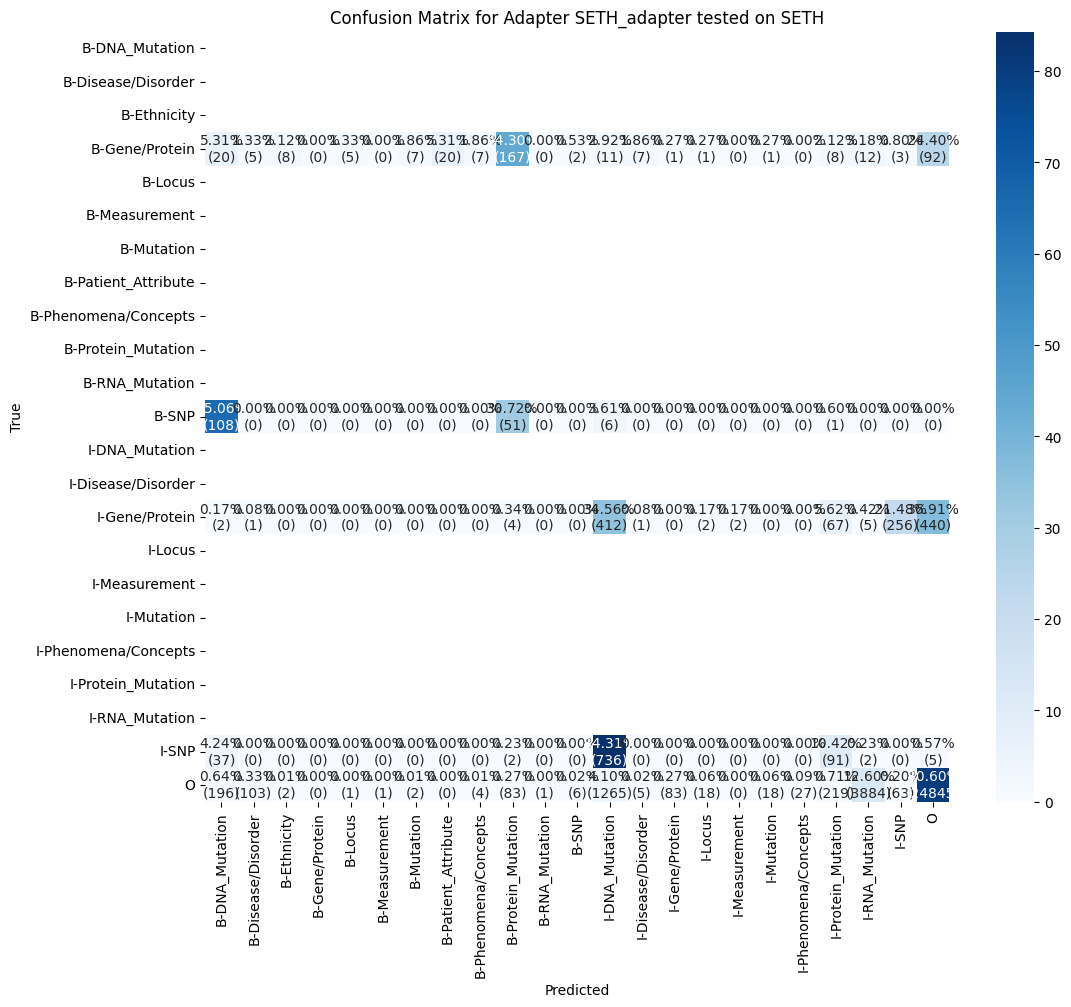

Testen auf Variome-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'O', 'B-DNA_Mutation', 'B-DNA_Mutation']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'I-RNA_Mutation', 'B-DNA_Mutation', 'I-Protein_Mutation', 'I-RNA_Mutation', 'I-RNA_Mutation', 'O', 'I-DNA_Mutation', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['I-DNA_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O', 'I-RNA_Mutation', 'I-Protein_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O']

Satz 5

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


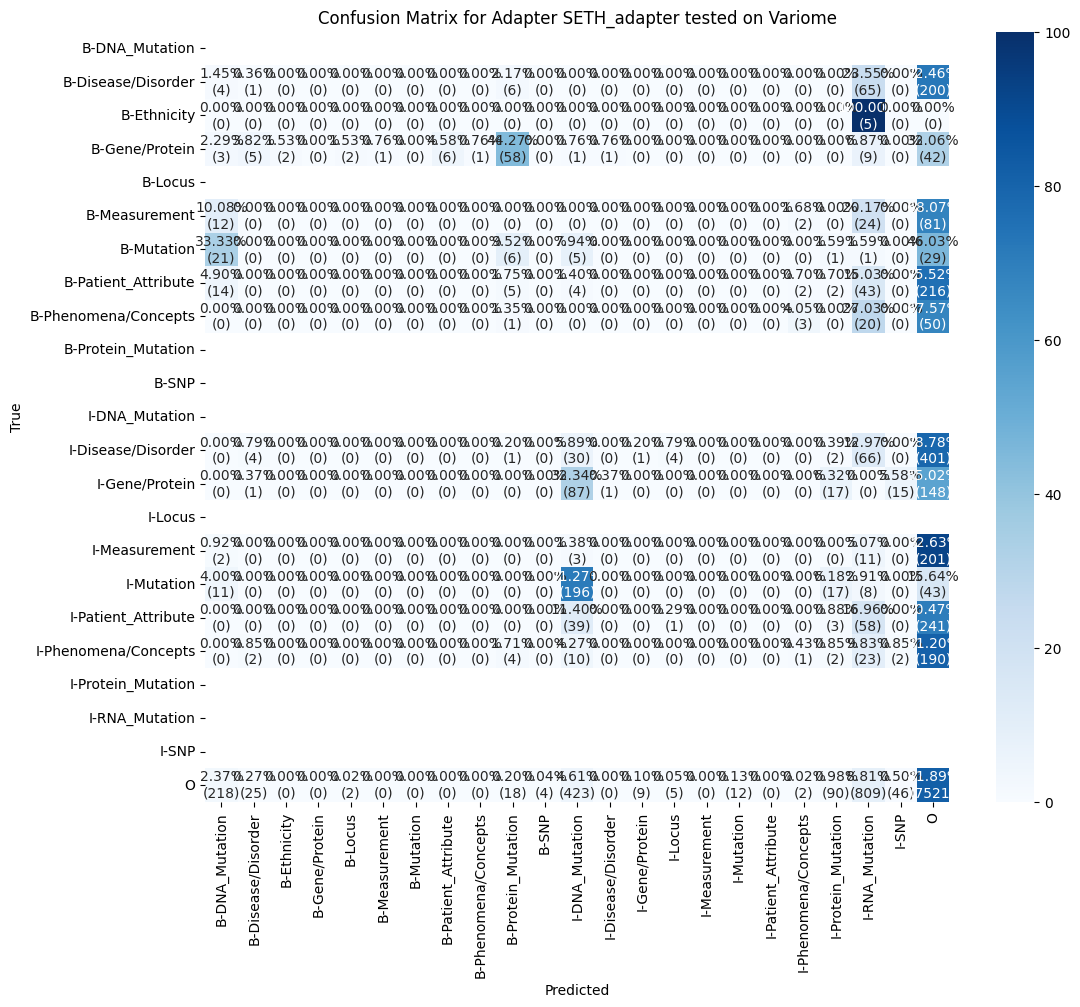

Testen auf Variome120-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'O', 'B-DNA_Mutation', 'B-DNA_Mutation']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'I-RNA_Mutation', 'B-DNA_Mutation', 'I-Protein_Mutation', 'I-RNA_Mutation', 'I-RNA_Mutation', 'O', 'I-DNA_Mutation', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['I-DNA_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O', 'I-RNA_Mutation', 'I-Protein_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O']

Satz 5

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


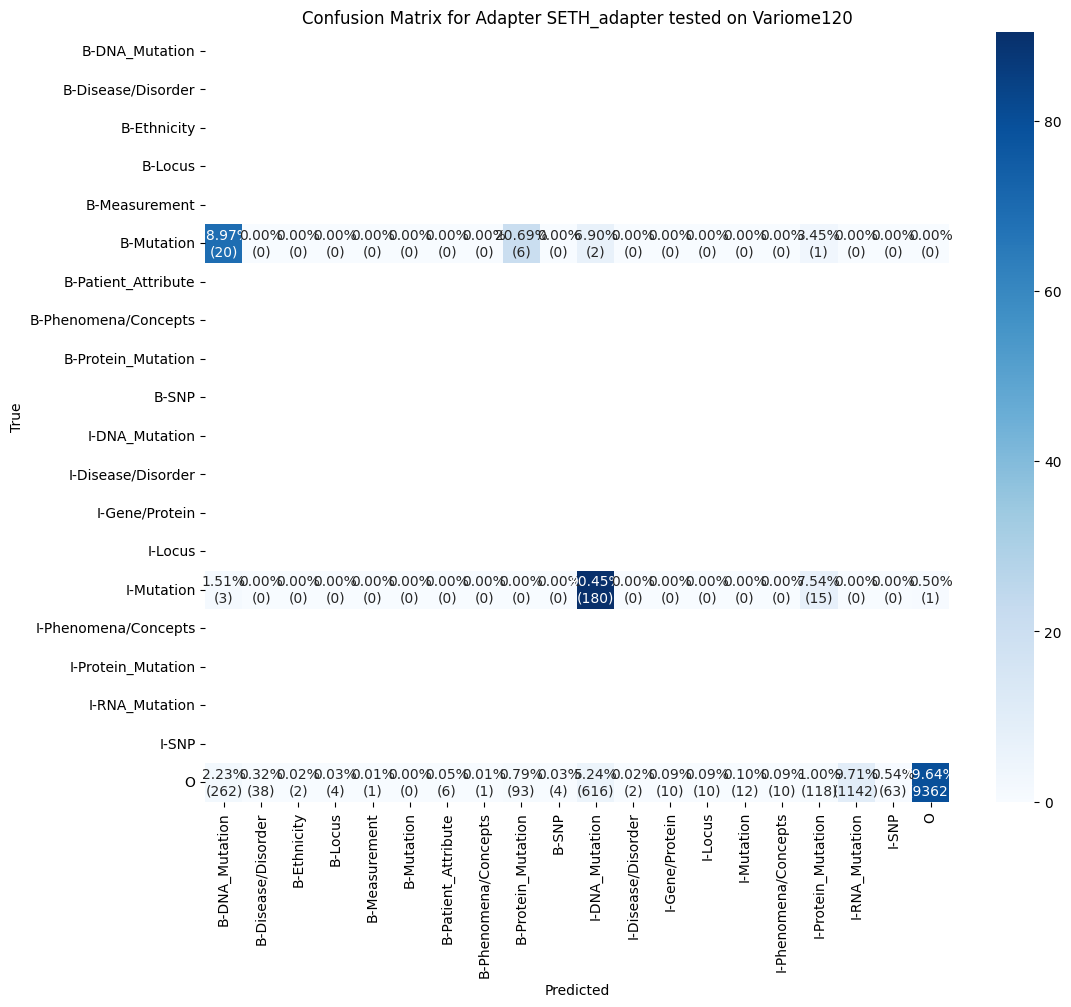

Testen auf Amia-Testset...


  0%|          | 0/63 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'I-DNA_Mutation', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['B-DNA_Mutation', 'O', 'I-RNA_Mutation', 'O', 'O', 'O', 'B-Protein_Mutation', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['B-DNA_Mutation', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'I-RNA_Mutation', 'I-RNA_Mutation', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-Disease/Disorder']

Satz 5 - Wahre Labels:
['O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['B-DNA_Mutation', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


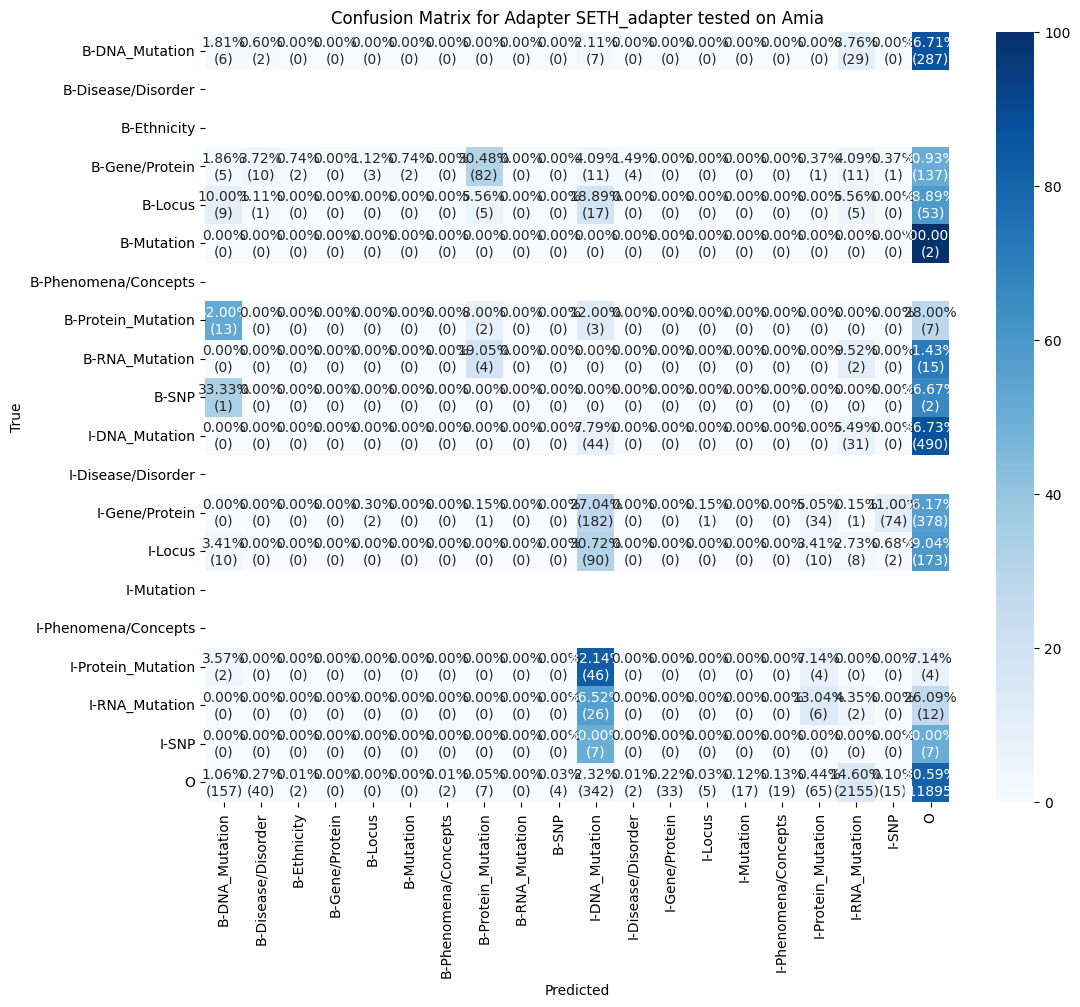

Testen auf TmVar-Testset...


  0%|          | 0/243 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'I-RNA_Mutation', 'B-Protein_Mutation', 'I-Protein_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['I-RNA_Mutation', 'O', 'I-RNA_Mutation', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'I-RNA_Mutation', 'O', 'O', 'O', 'O', 'O', 'O', 'I-RNA_Mutation', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


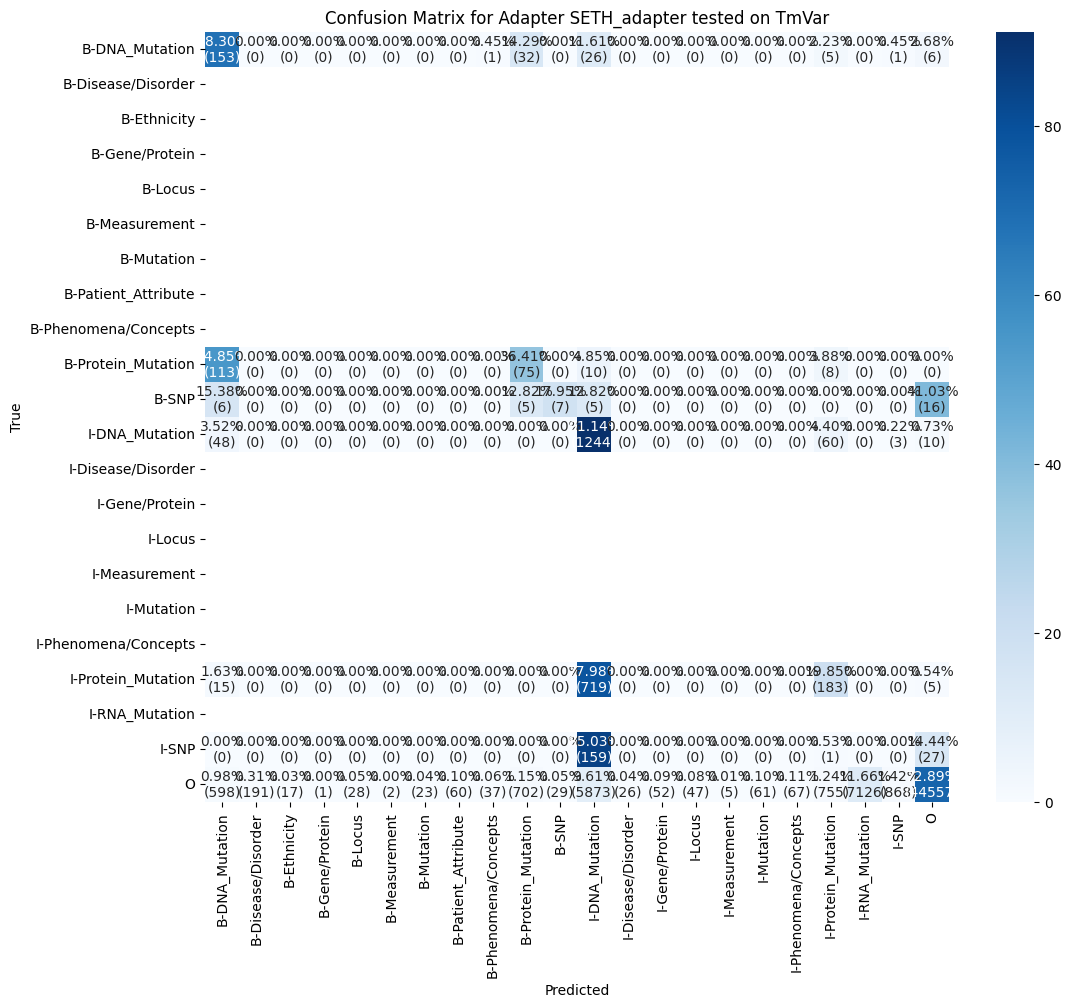


Evaluierung des Adapters Variome_adapter...
Aktiviere Adapter: Variome_adapter
Testen auf SETH-Testset...


  0%|          | 0/119 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'I-Phenomena/Concepts', 'I-Phenomena/Concepts', 'I-Phenomena/Concepts', 'O', 'O', 'O', 'O', 'I-Phenomena/Concepts', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['I-Locus', 'O', 'O', 'O', 'O', 'O', 'I-Locus', 'I-Locus', 'O', 'I-Phenomena/Concepts']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['I-Locus', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Sa

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


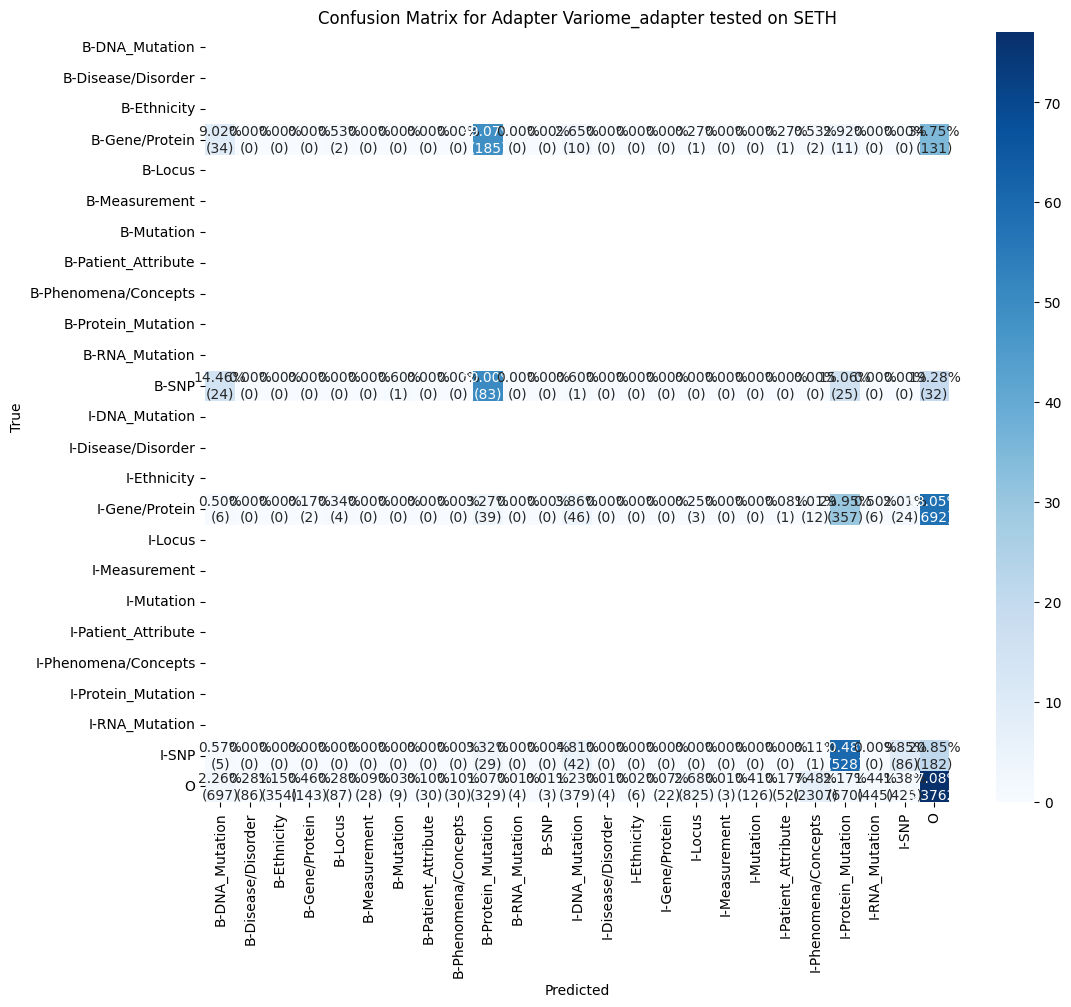

Testen auf Variome-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'I-Locus', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-DNA_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['B-Ethnicity', 'B-Ethnicity', 'O', 'B-Ethnicity']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', '

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


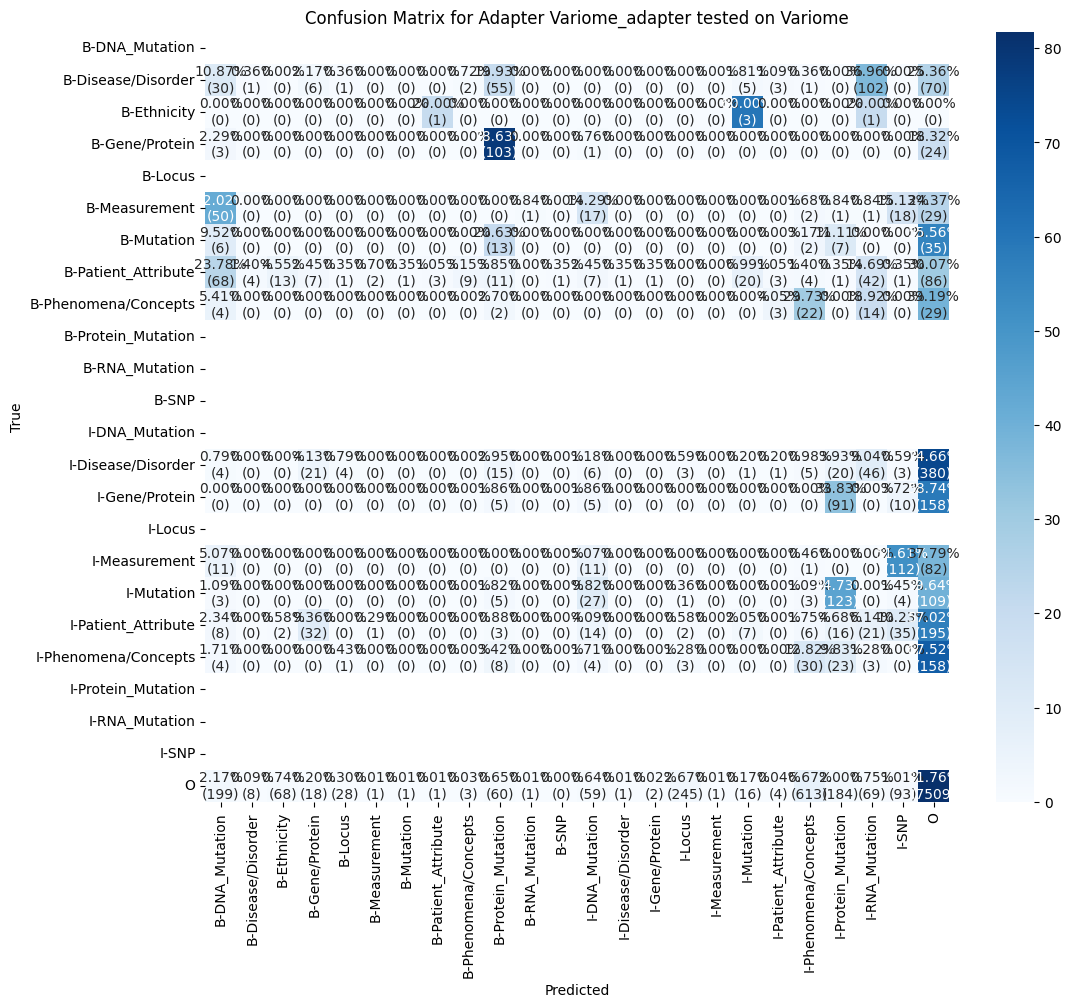

Testen auf Variome120-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'I-Locus', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-DNA_Mutation', 'I-DNA_Mutation', 'I-DNA_Mutation', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['B-Ethnicity', 'B-Ethnicity', 'O', 'B-Ethnicity']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', '

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


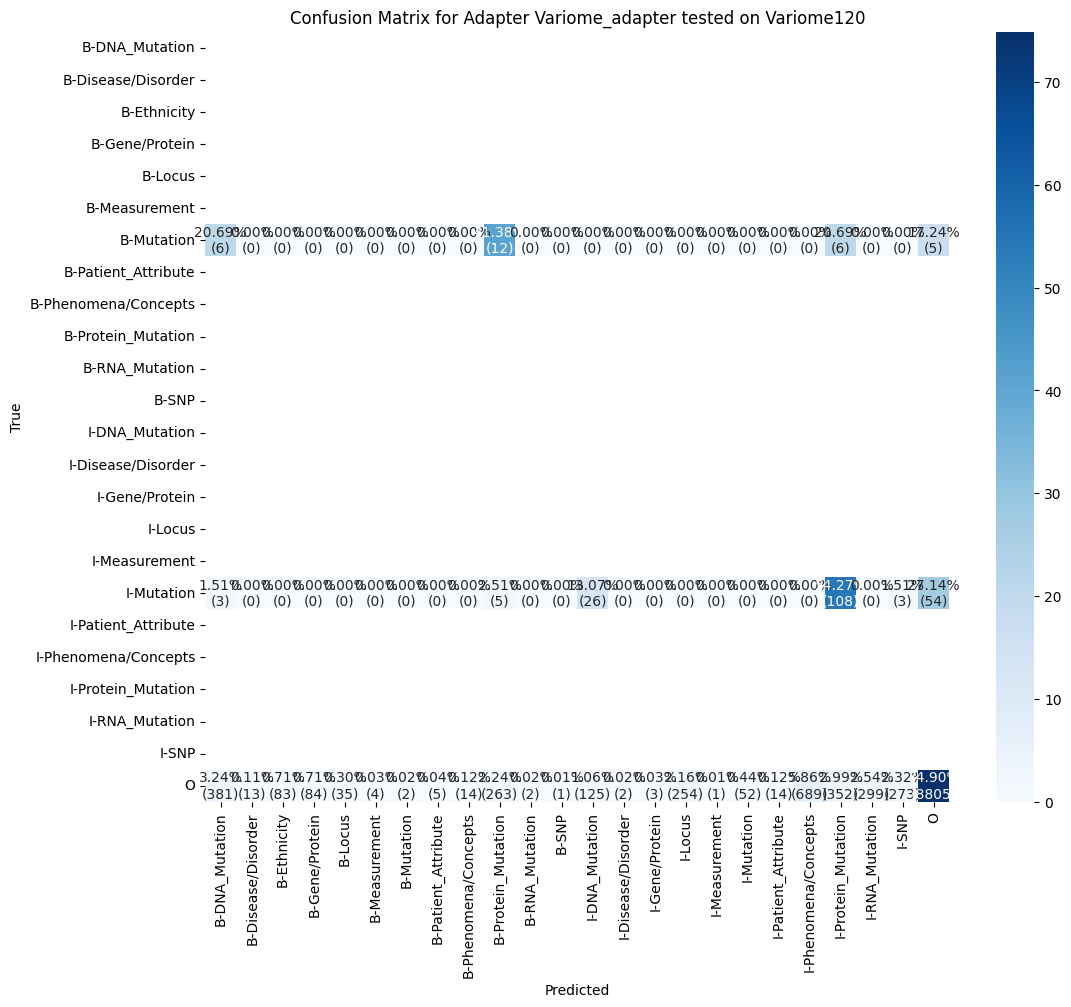

Testen auf Amia-Testset...


  0%|          | 0/63 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['I-Phenomena/Concepts', 'O', 'O', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'O', 'B-Ethnicity', 'B-Gene/Protein']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'I-DNA_Mutation', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['B-DNA_Mutation', 'B-DNA_Mutation', 'O', 'O', 'O', 'O', 'B-Protein_Mutation', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['B-DNA_Mutation', 'B-DNA_Mutation', 'B-DNA_Mutation']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


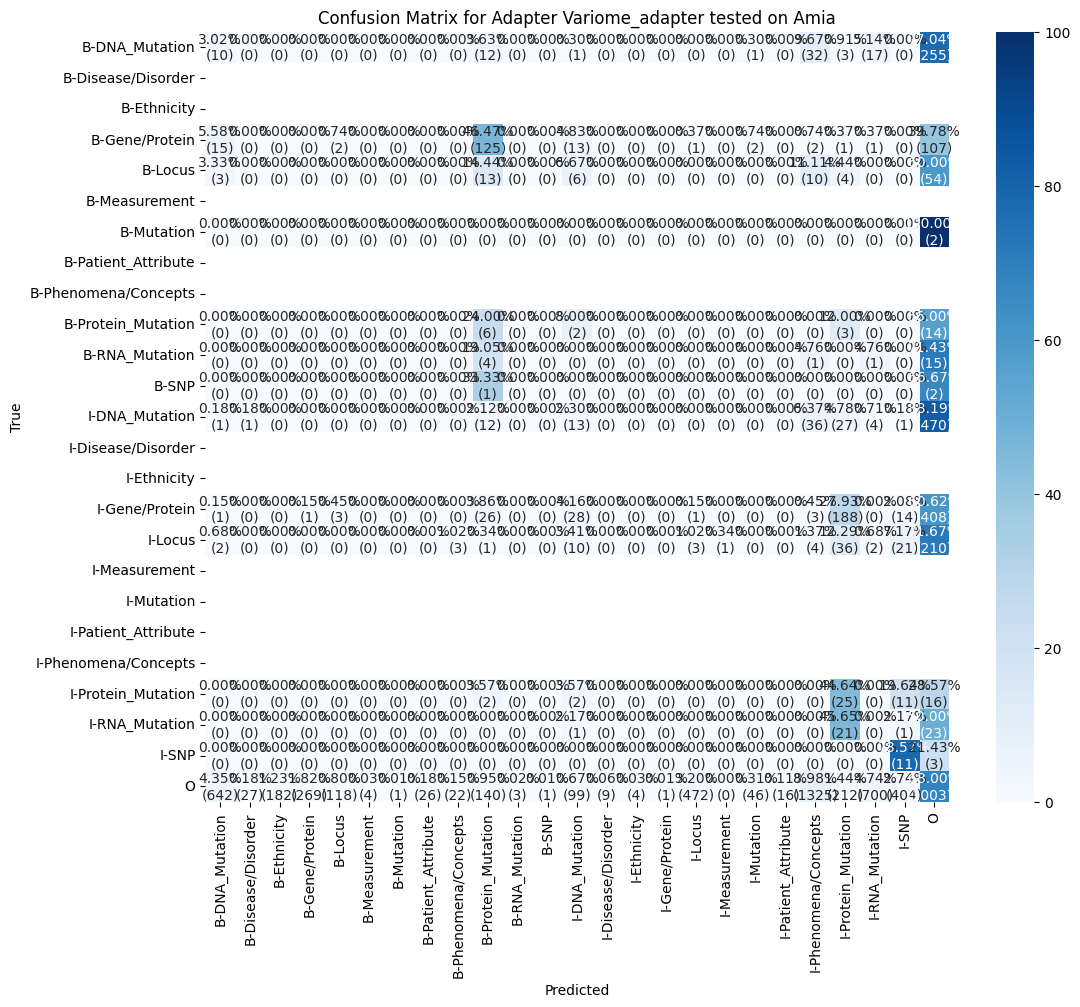

Testen auf TmVar-Testset...


  0%|          | 0/243 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'B-Protein_Mutation', 'I-Protein_Mutation', 'O', 'I-SNP', 'O', 'O', 'O', 'B-DNA_Mutation']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-Phenomena/Concepts', 'O', 'I-Phenomena/Concepts', 'O', 'O', 'O', 'I-Phenomena/Concepts']

Satz 3 - Wahre Labels:
['O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'I-Phenomena/Concepts', 'O', 'B-Gene/Protein', 'O', 'O', 'O', 'O', 'I-Phenomena/Concepts', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


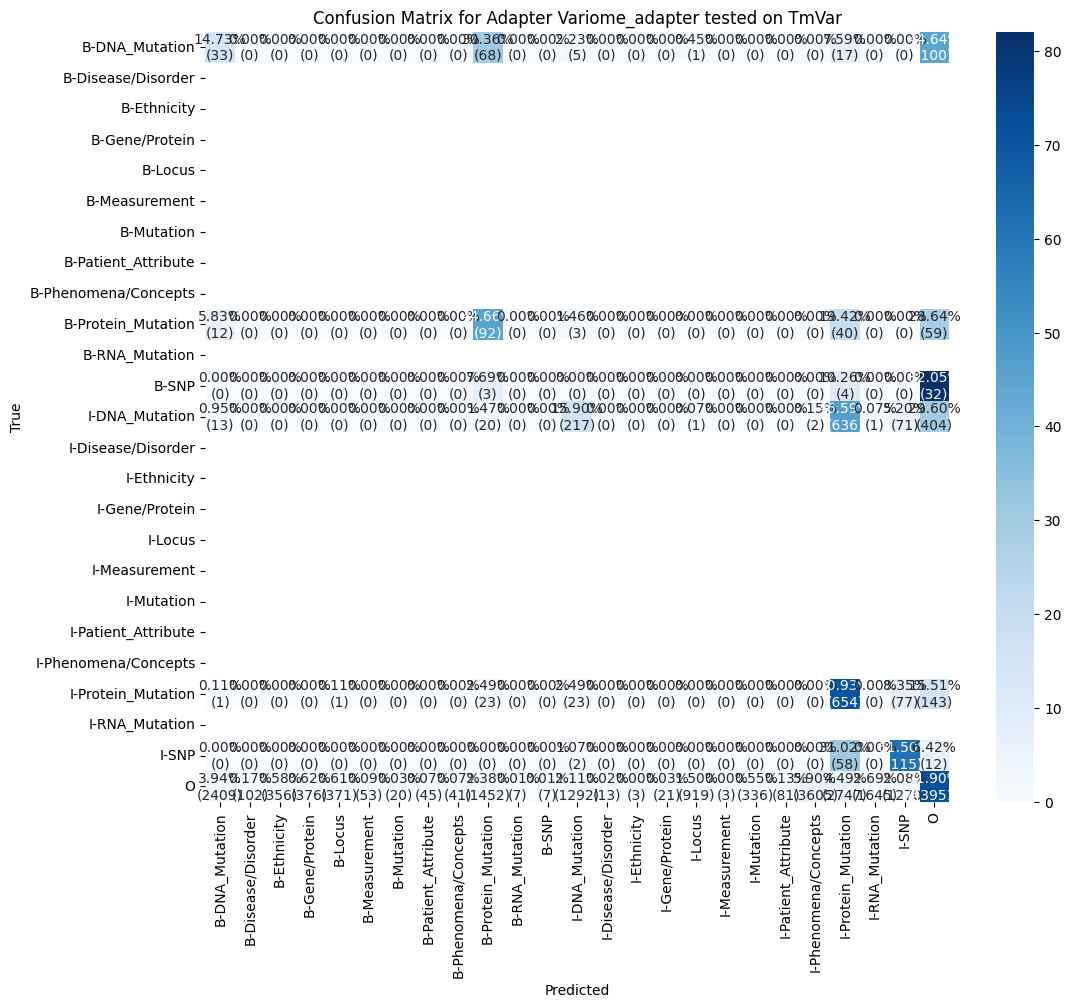


Evaluierung des Adapters Variome120_adapter...
Aktiviere Adapter: Variome120_adapter
Testen auf SETH-Testset...


  0%|          | 0/119 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'I-SNP', 'I-SNP', 'I-SNP', 'O', 'O', 'O', 'I-SNP', 'I-SNP', 'I-SNP']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


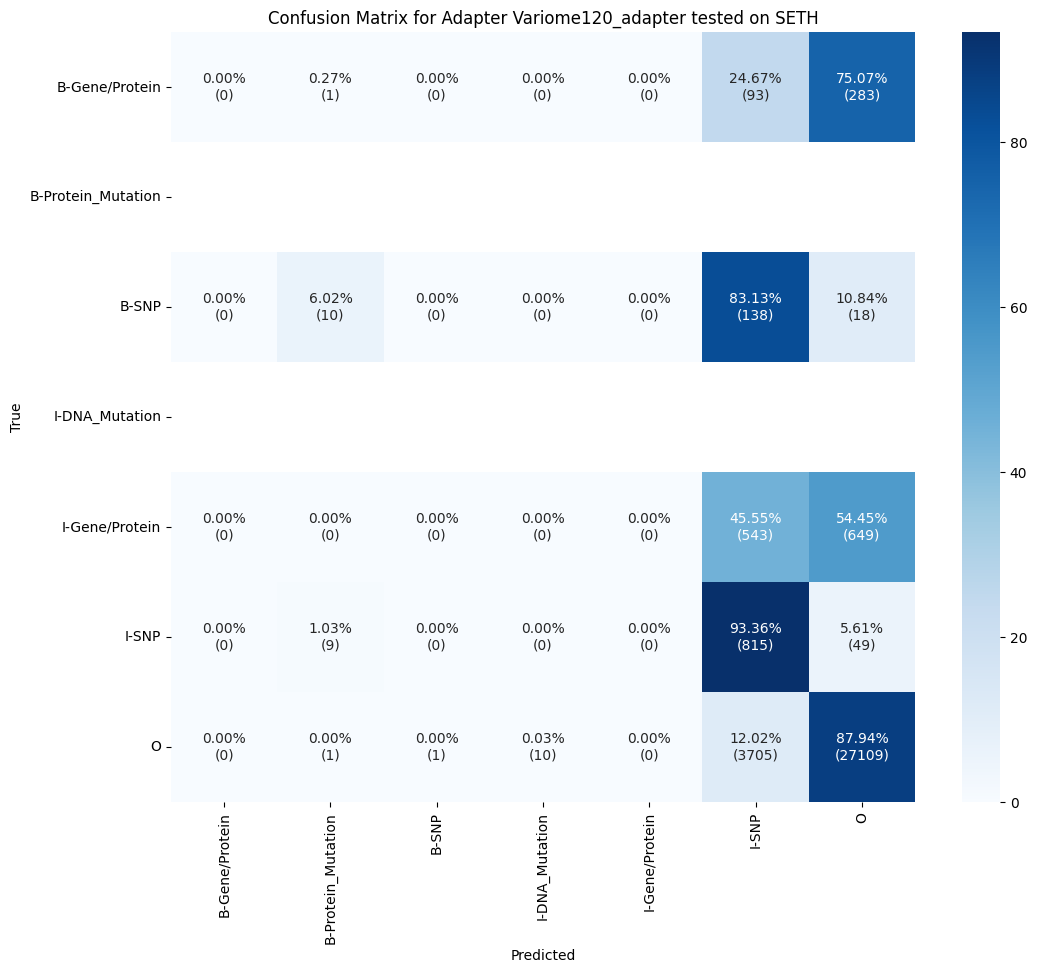

Testen auf Variome-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['I-SNP', 'I-SNP', 'I-SNP', 'O', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-SNP', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['I-SNP', 'O', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'I-SNP', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'I-SNP', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


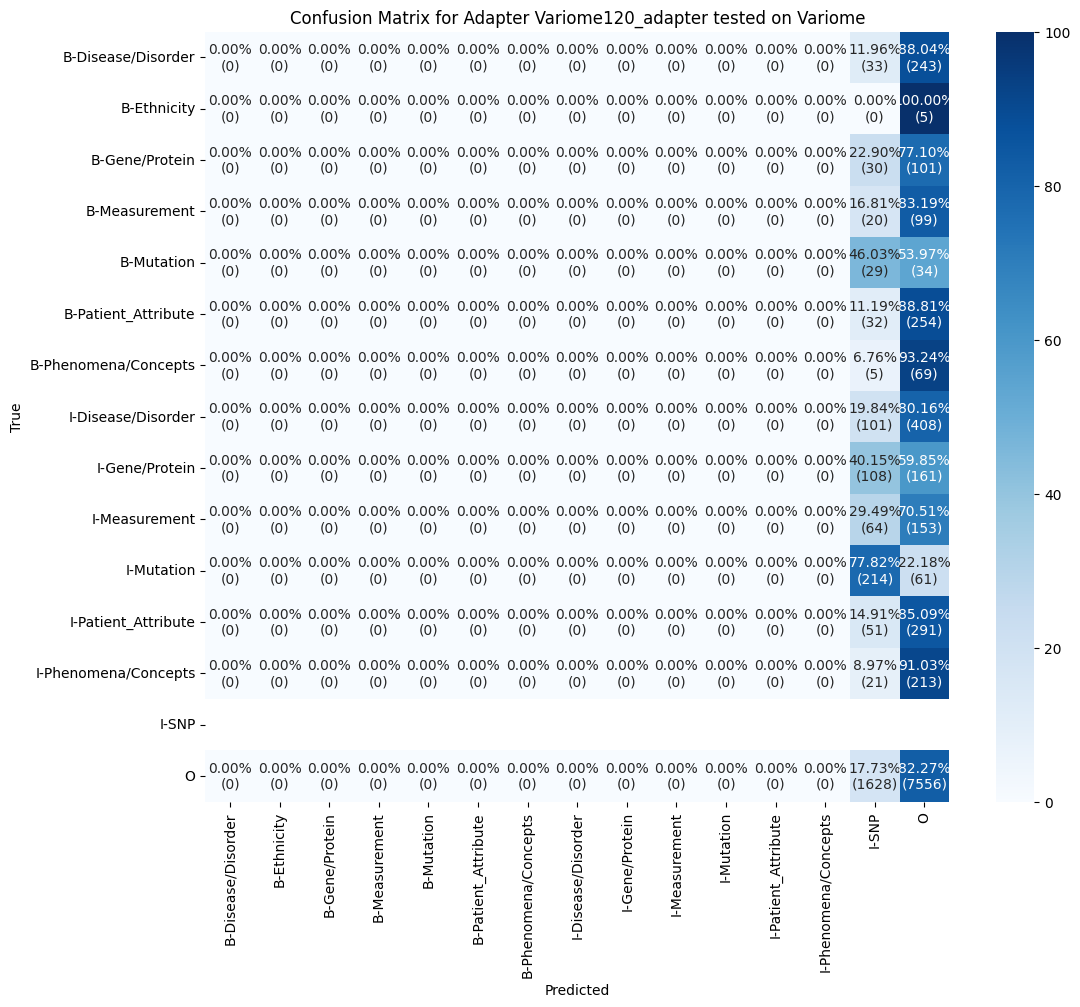

Testen auf Variome120-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['I-SNP', 'I-SNP', 'I-SNP', 'O', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'I-SNP', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-SNP', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['I-SNP', 'O', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'I-SNP', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'I-SNP', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


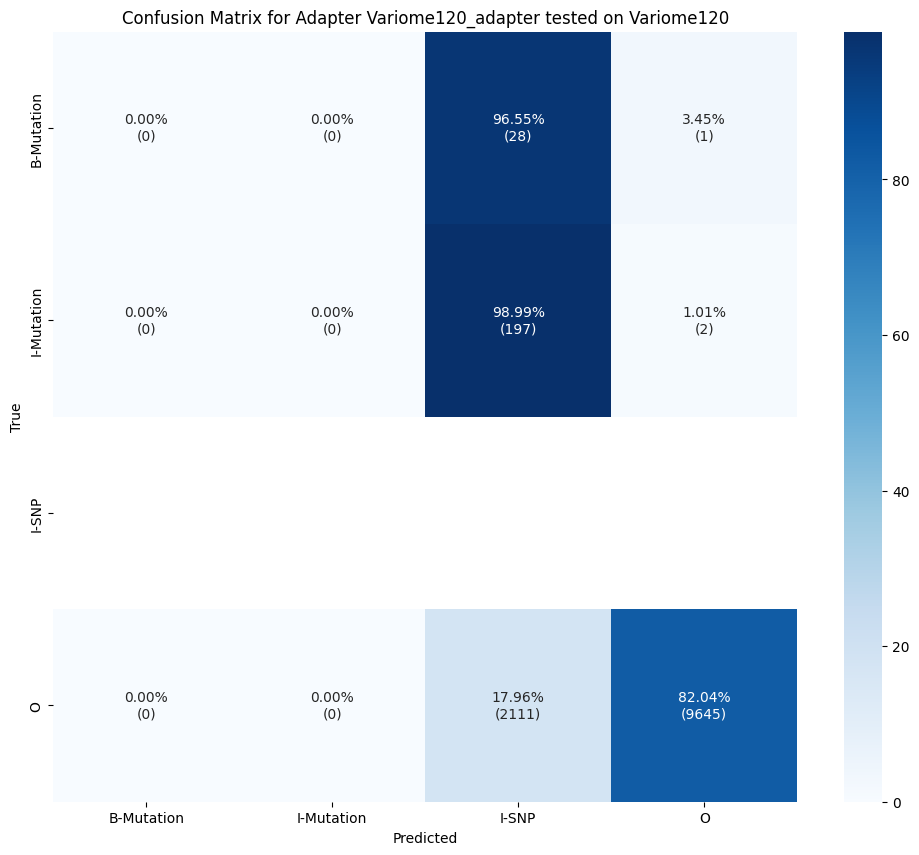

Testen auf Amia-Testset...


  0%|          | 0/63 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'I-DNA_Mutation', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-SNP', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['I-SNP', 'I-SNP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O'

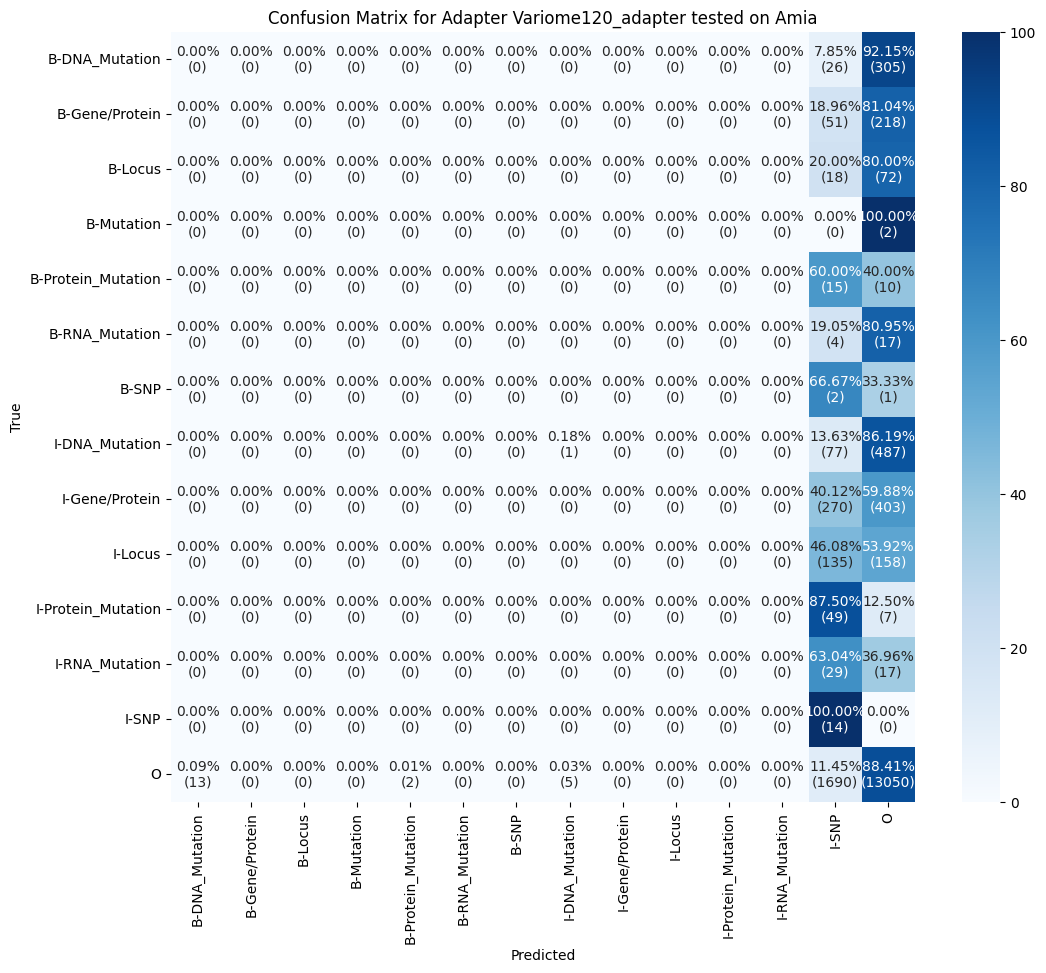

Testen auf TmVar-Testset...


  0%|          | 0/243 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-SNP', 'I-SNP', 'I-SNP', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-SNP', 'I-SNP', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

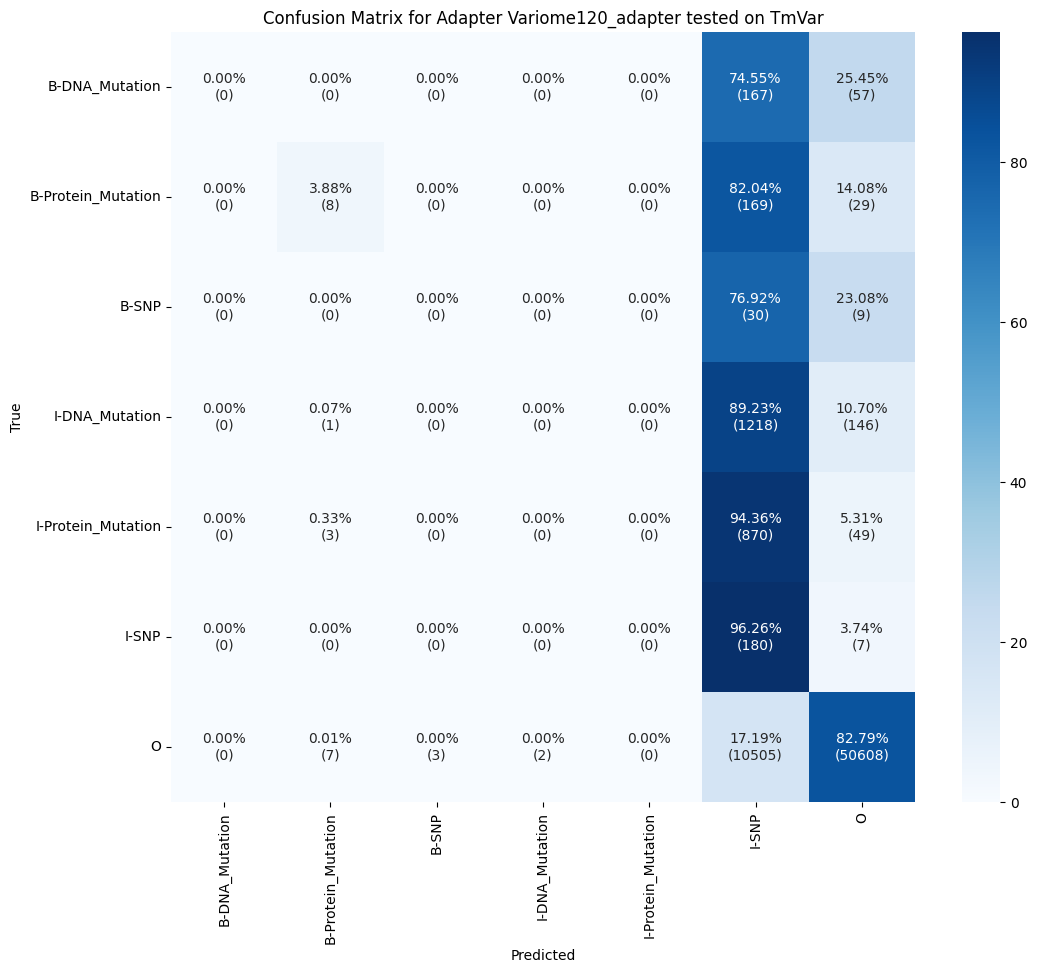


Evaluierung des Adapters Amia_adapter...
Aktiviere Adapter: Amia_adapter
Testen auf SETH-Testset...


  0%|          | 0/119 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


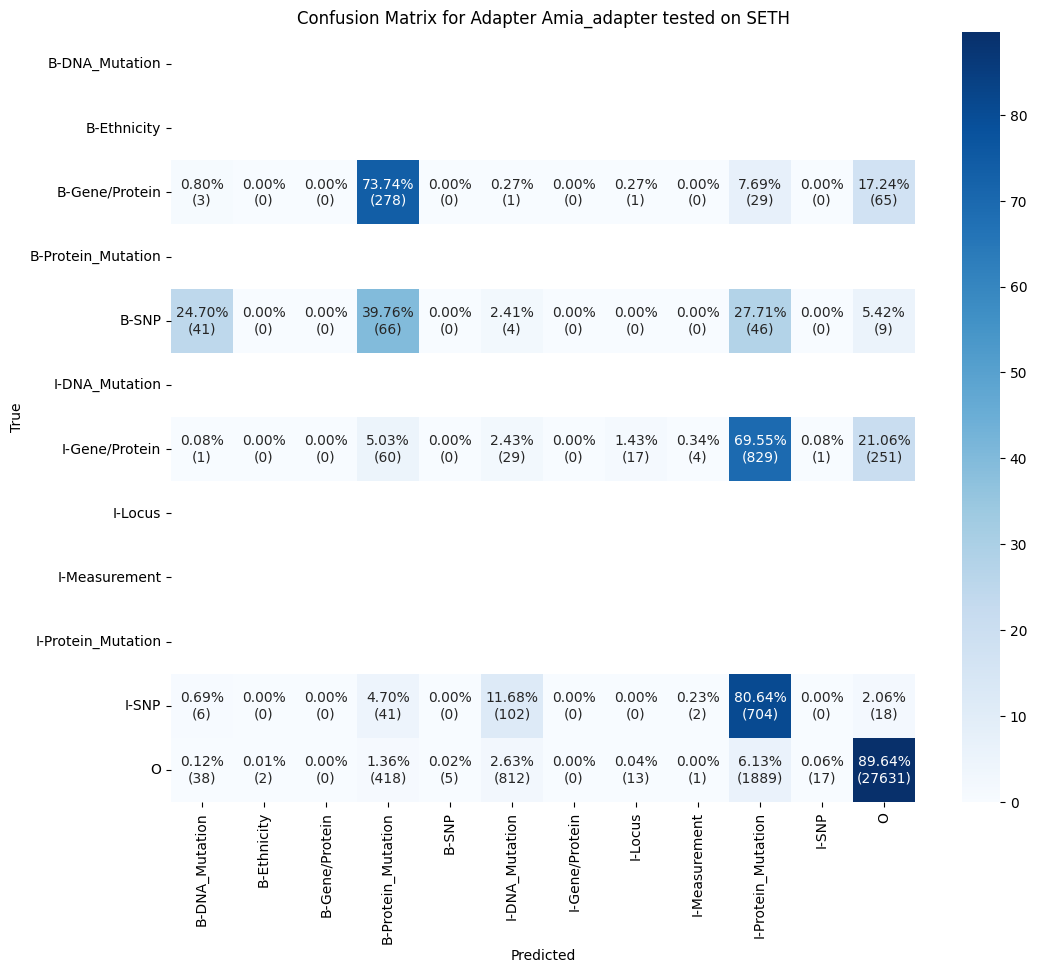

Testen auf Variome-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['B-DNA_Mutation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'I-Protein_Mutation', 'I-Protein_Mutation', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-Protein_Mutation', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['I-Protein_Mutation', 'I-Protein_Mutation', 'I-Protein_Mutation', 'O', 'O', 'O', 'I-DNA_Mutation', 'O', 'I-Protein_Mutation', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-DNA_Mutation']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte 

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


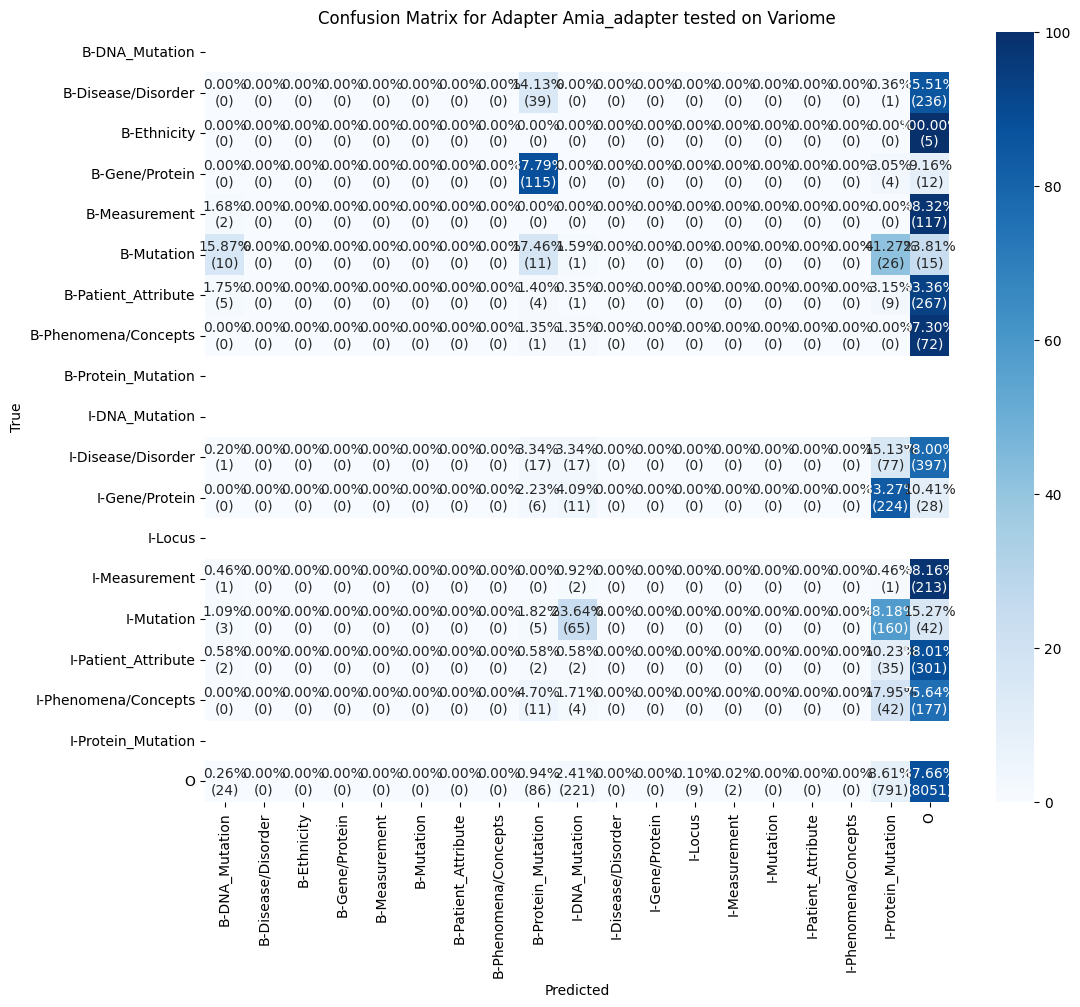

Testen auf Variome120-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['B-DNA_Mutation', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'I-Protein_Mutation', 'I-Protein_Mutation', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'I-Protein_Mutation', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['I-Protein_Mutation', 'I-Protein_Mutation', 'I-Protein_Mutation', 'O', 'O', 'O', 'I-DNA_Mutation', 'O', 'I-Protein_Mutation', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-DNA_Mutation']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte 

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


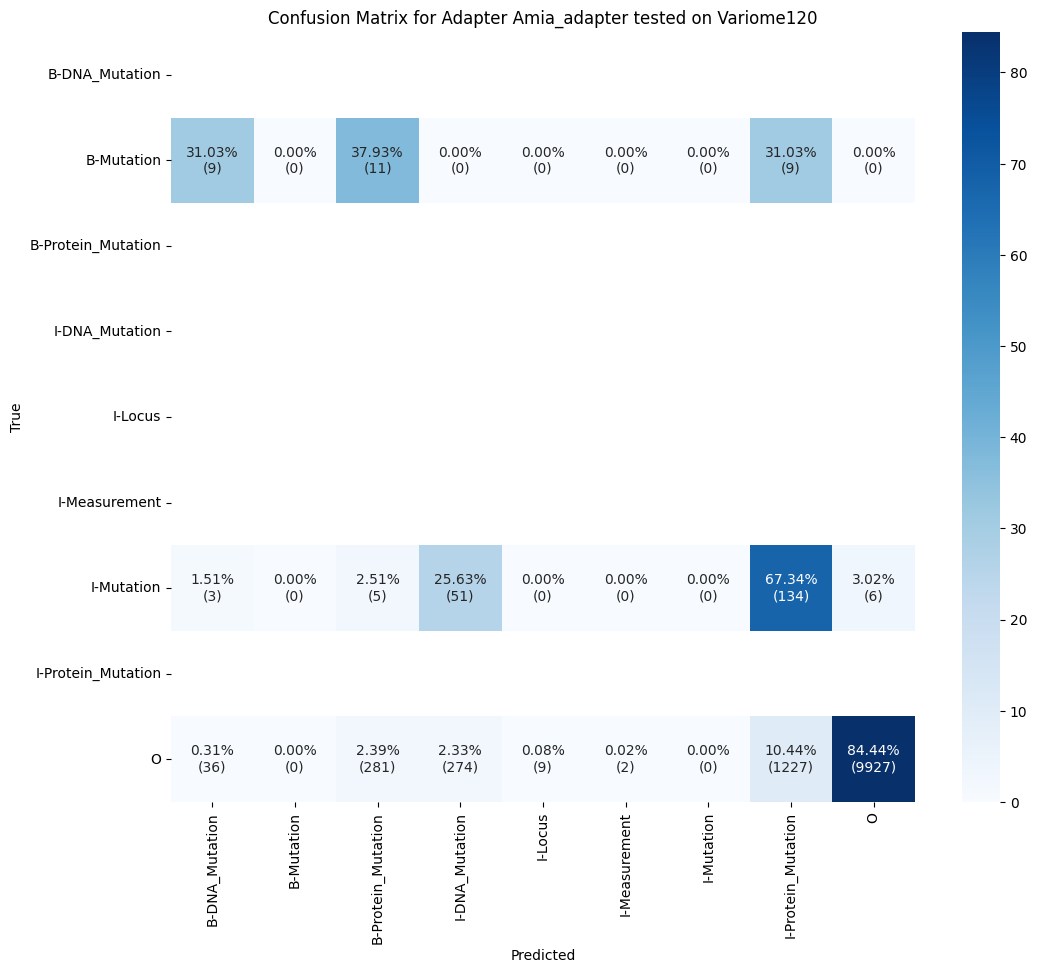

Testen auf Amia-Testset...


  0%|          | 0/63 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'I-DNA_Mutation', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'I-Protein_Mutation', 'O', 'O', 'B-Protein_Mutation', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', '

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


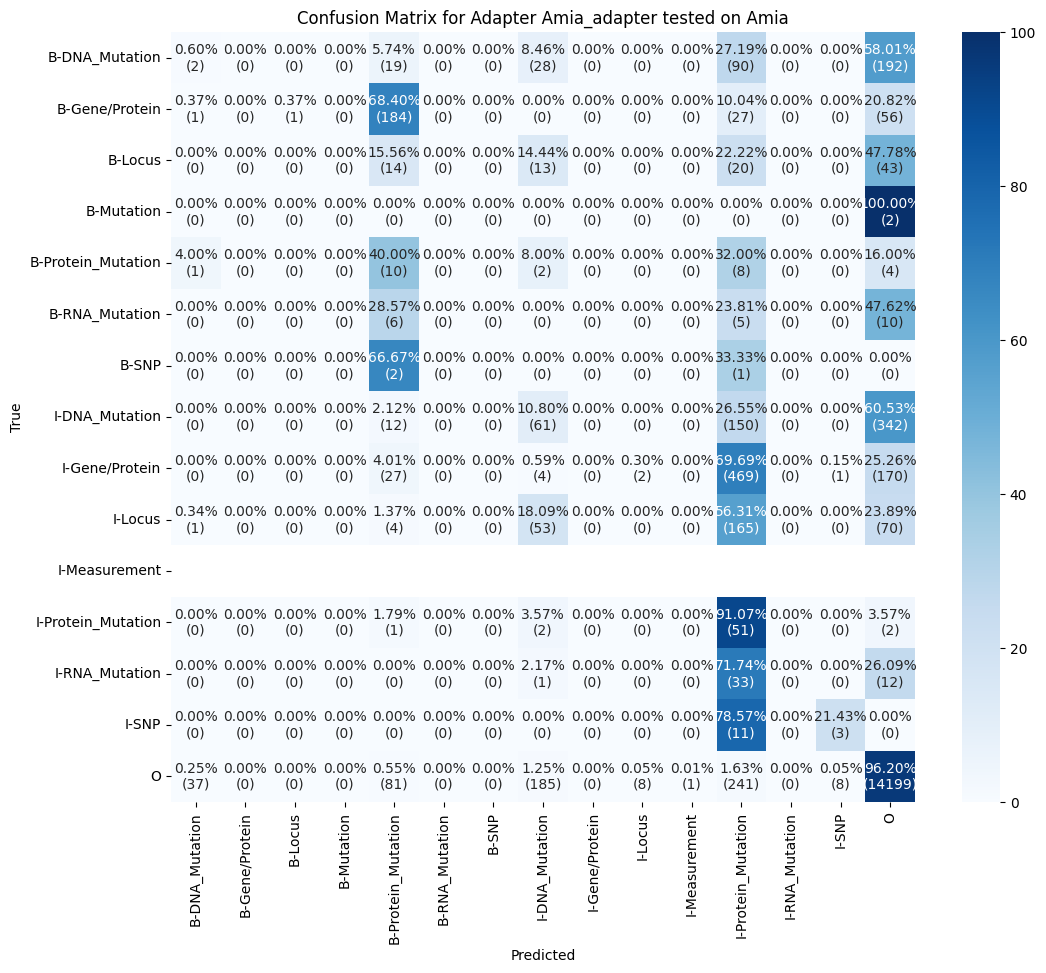

Testen auf TmVar-Testset...


  0%|          | 0/243 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'B-Protein_Mutation', 'I-Protein_Mutation', 'I-Protein_Mutation', 'I-Protein_Mutation', 'I-Protein_Mutation', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


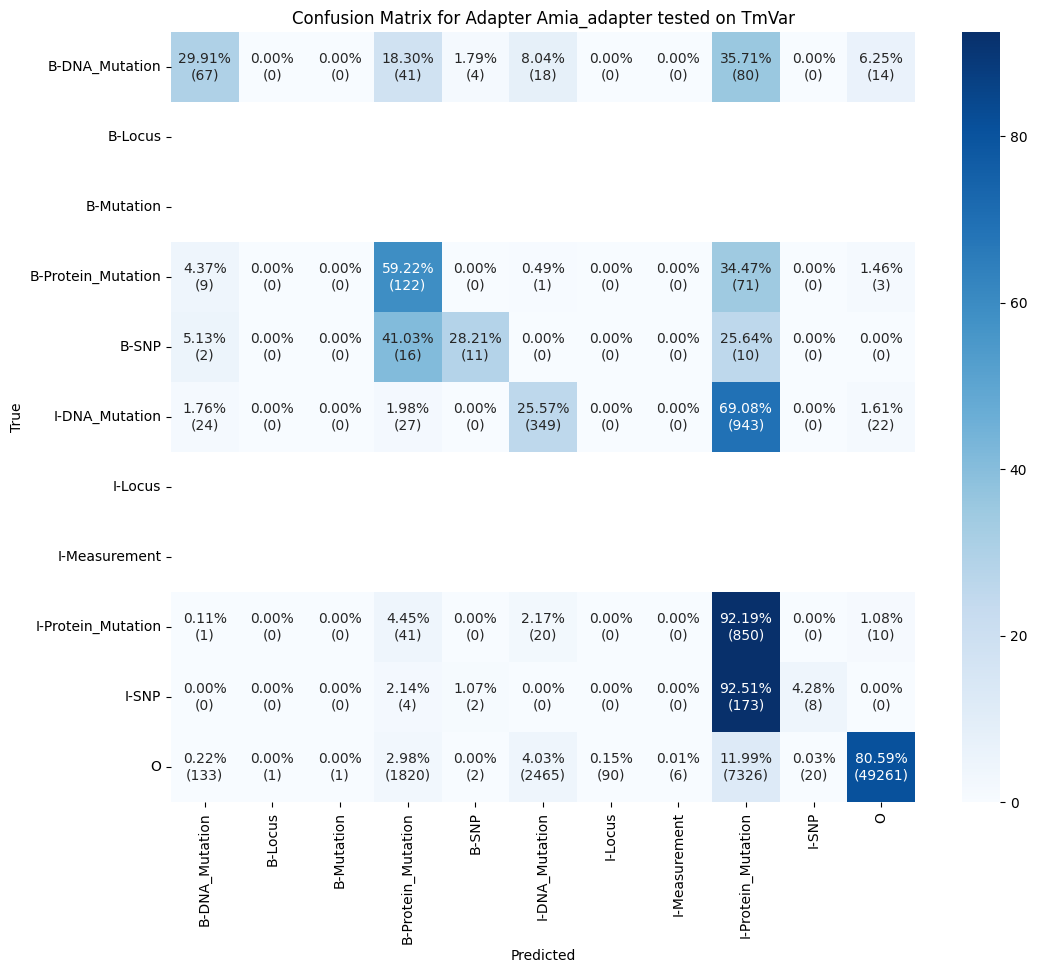


Evaluierung des Adapters TmVar_adapter...
Aktiviere Adapter: TmVar_adapter
Testen auf SETH-Testset...


  0%|          | 0/119 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O',

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


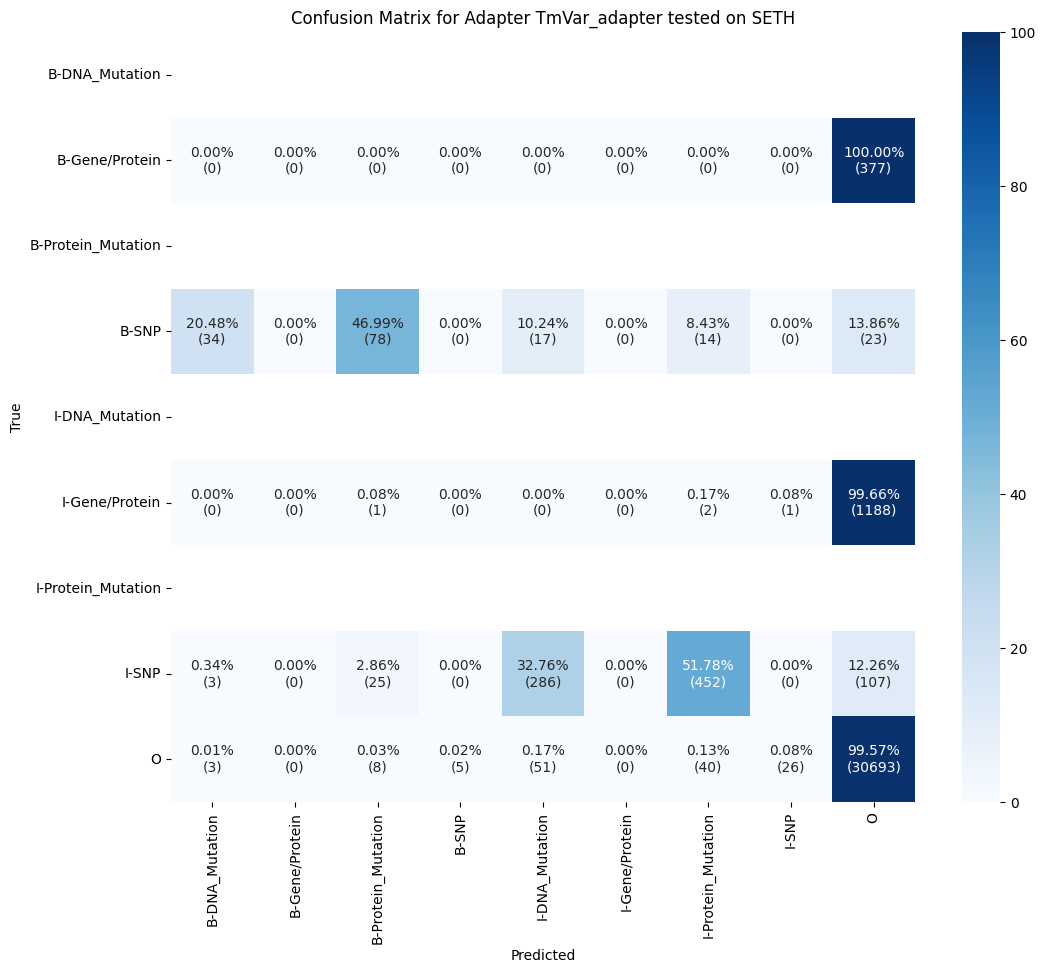

Testen auf Variome-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


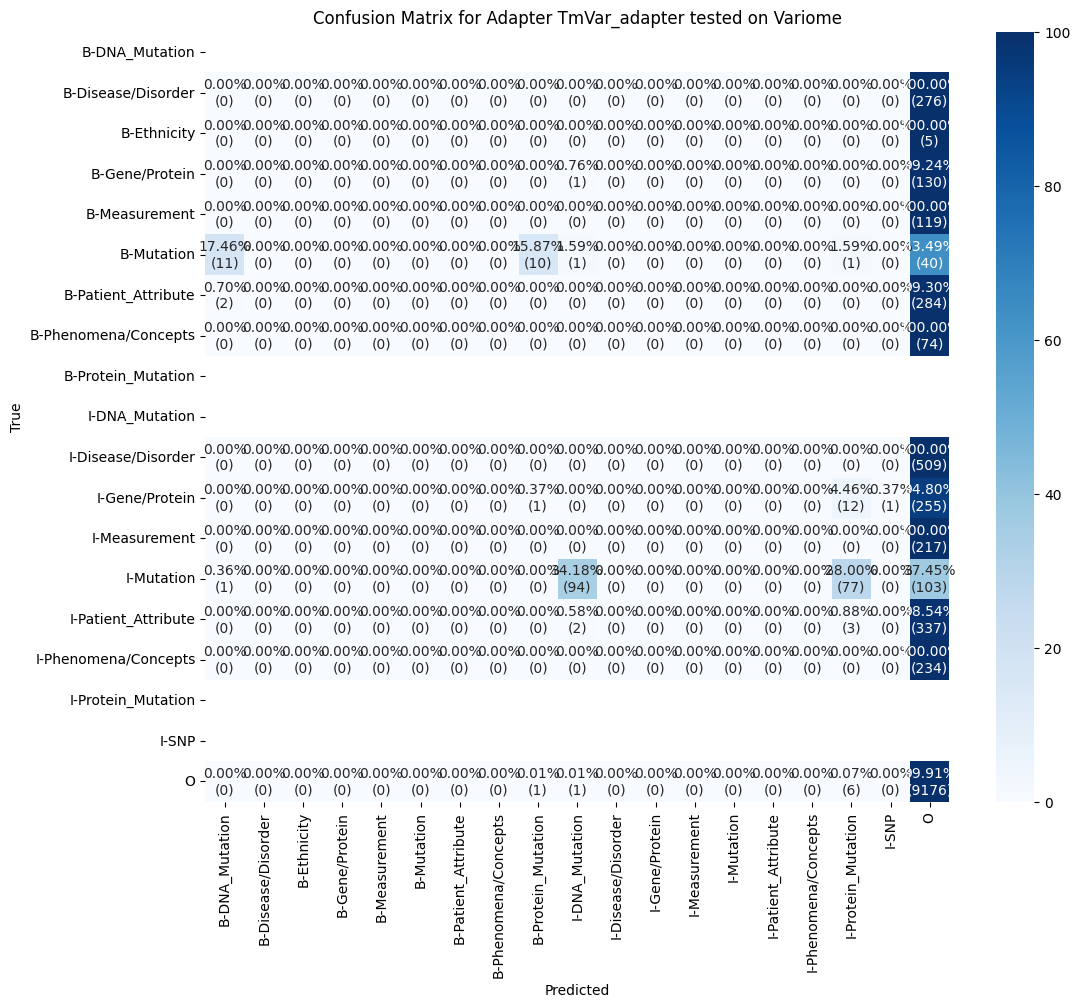

Testen auf Variome120-Testset...


  0%|          | 0/47 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte L

C:\Users\denis\AppData\Local\Temp\ipykernel_1632\1129670037.py:50: RuntimeWarning: invalid value encountered in divide
  cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100


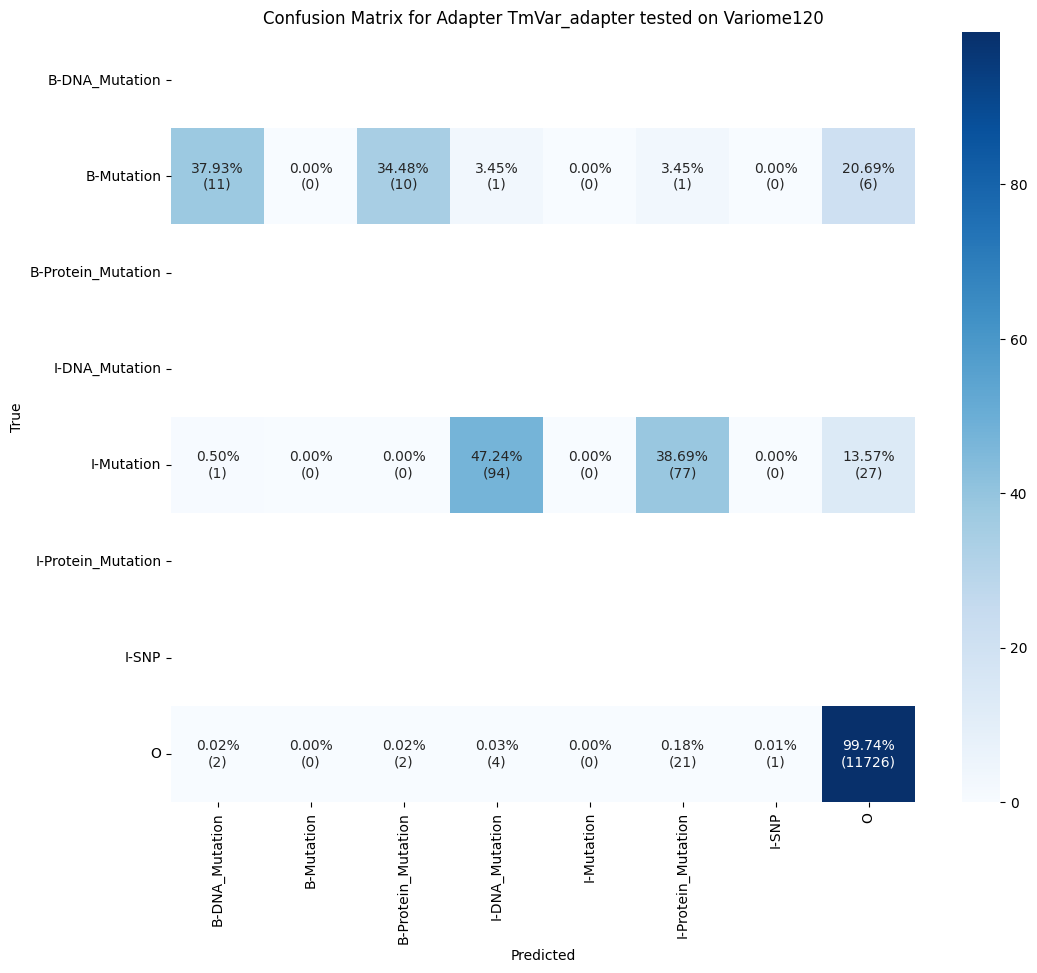

Testen auf Amia-Testset...


  0%|          | 0/63 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'I-DNA_Mutation', 'O', 'O', 'B-Gene/Protein', 'I-Gene/Protein', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

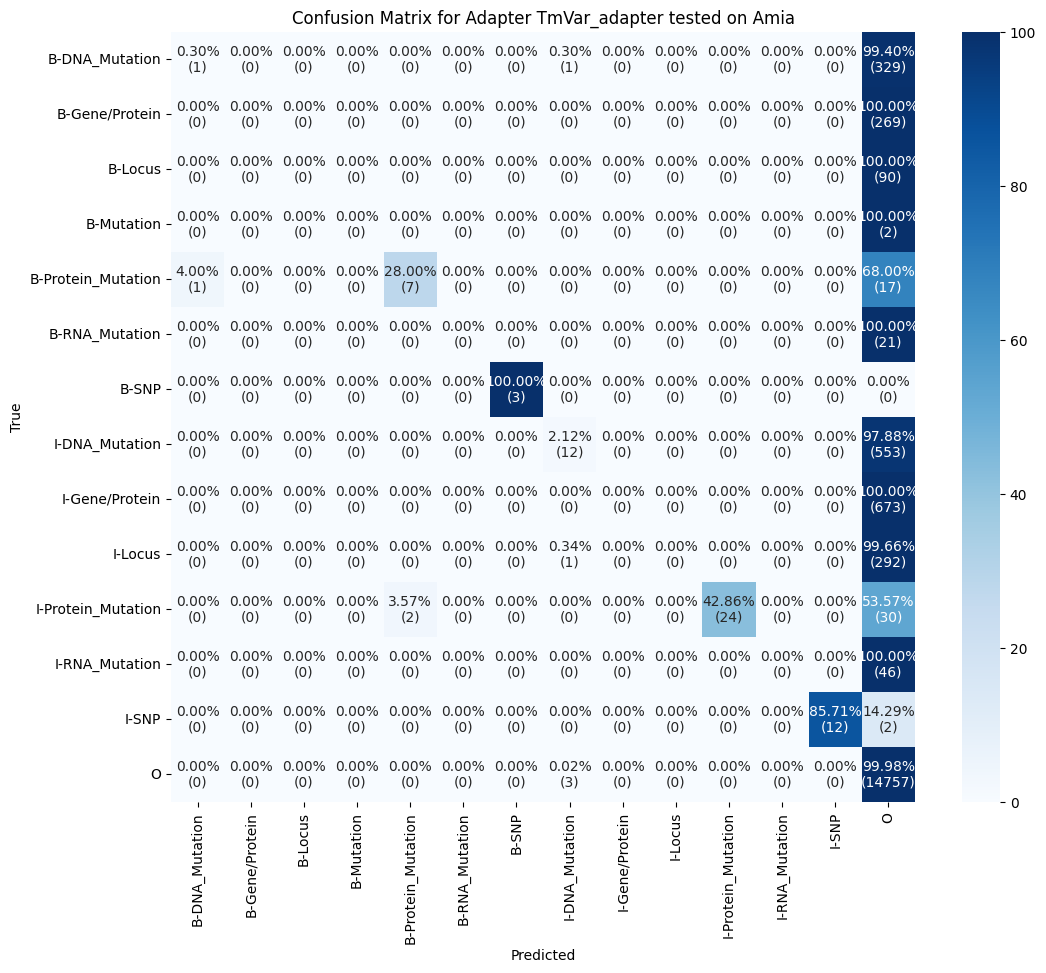

Testen auf TmVar-Testset...


  0%|          | 0/243 [00:00<?, ?it/s]


=== DEBUGGING ===

Satz 1 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 1 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 2 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 2 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 3 - Wahre Labels:
['O', 'O']
Satz 3 - Vorhergesagte Labels:
['O', 'O']

Satz 4 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 4 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 5 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 5 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 6 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 6 - Vorhergesagte Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Satz 7 - Wahre Labels:
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Satz 7 - Vorhergesagte Labels:
['O', 'O', 'O

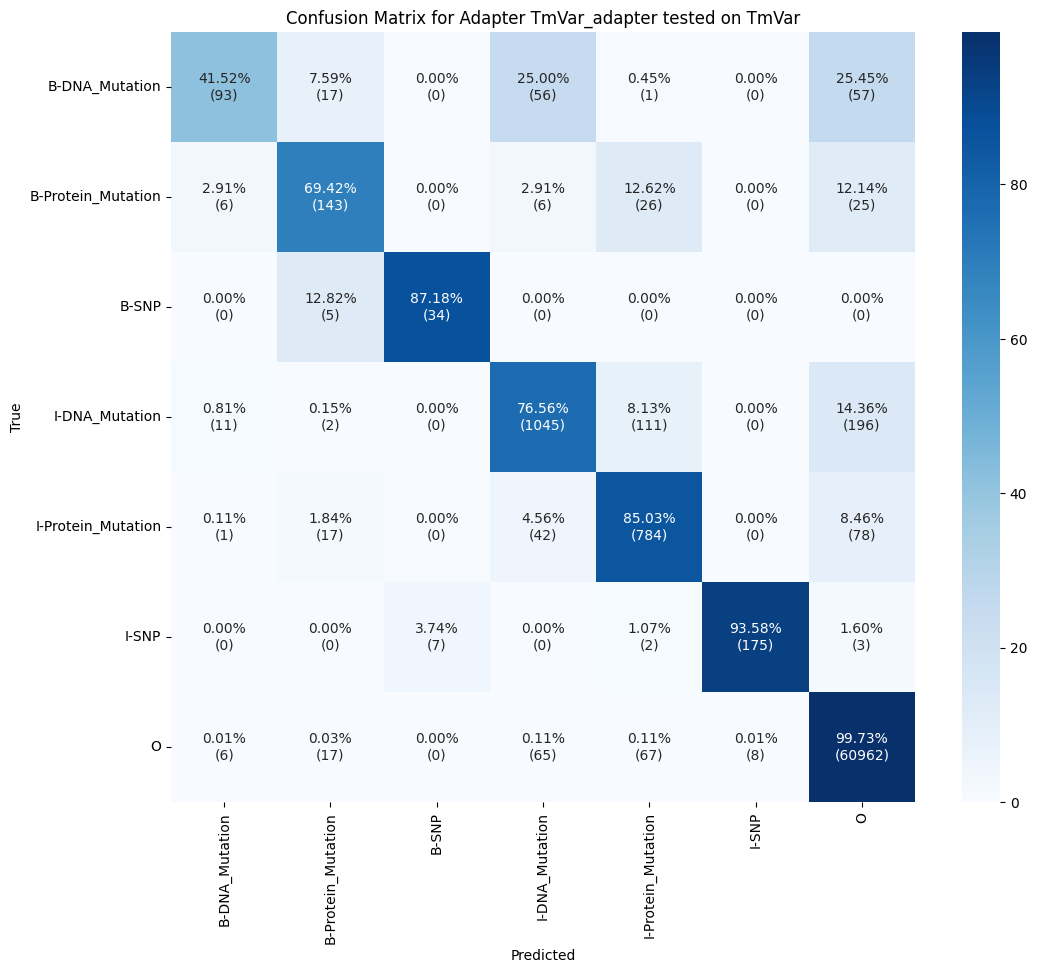


Zusammenfassung der Ergebnisse:
+----+--------------------+-------------+------------+--------+-------------+----------+
|    | Adapter            | Tested_on   |   accuracy |     f1 |   precision |   recall |
+====+====================+=============+============+========+=============+==========+
|  0 | SETH_adapter       | SETH        |     0.7431 | 0.0000 |      0.0000 |   0.0000 |
+----+--------------------+-------------+------------+--------+-------------+----------+
|  1 | SETH_adapter       | Variome     |     0.6278 | 0.0008 |      0.0006 |   0.0010 |
+----+--------------------+-------------+------------+--------+-------------+----------+
|  2 | SETH_adapter       | Variome120  |     0.7812 | 0.0000 |      0.0000 |   0.0000 |
+----+--------------------+-------------+------------+--------+-------------+----------+
|  3 | SETH_adapter       | Amia        |     0.6970 | 0.0028 |      0.0019 |   0.0053 |
+----+--------------------+-------------+------------+--------+-------------+

In [19]:
# Evaluation und Zusammenfassung aller Modelle
results_summary = []

def evaluate_all_adapters():
    for adapter_name in trained_adapters:
        print(f"\nEvaluierung des Adapters {adapter_name}...")
        activate_adapter(adapter_name)
        trainer = adapter_trainers[adapter_name]  # Hole den spezifischen Trainer für den Adapter

        for test_dataset_name, dataset in tokenized_datasets.items():
            print(f"Testen auf {test_dataset_name}-Testset...")

            # Predictions auf dem Testset
            predictions, labels, _ = trainer.predict(dataset["test"])
            predictions = np.argmax(predictions, axis=-1)

            # Bereite die Labels und Vorhersagen zur Auswertung vor
            # Bereite die Labels und Vorhersagen zur Auswertung vor
            true_labels = [[UNIFIED_LABELS[l] for l in label if l != -100] for label in labels]
            pred_labels = [[UNIFIED_LABELS[p] for (p, l) in zip(pred, label) if l != -100] 
                        for pred, label in zip(predictions, labels)]

            # Berechne seqeval-Metriken
            overall_metrics = metric.compute(predictions=pred_labels, references=true_labels, zero_division=1)

            # Flache die Labels und Vorhersagen für die Confusion-Matrix
            true_labels_flat = [label for sublist in true_labels for label in sublist]
            pred_labels_flat = [pred for sublist in pred_labels for pred in sublist]

            # Reduziere die Klassen auf tatsächlich vorkommende Labels
            unique_true_labels = set(true_labels_flat)
            unique_pred_labels = set(pred_labels_flat)
            relevant_classes = sorted(unique_true_labels.union(unique_pred_labels))

            # Berechne die Confusion-Matrix für relevante Klassen
            cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=relevant_classes)

            # Speichere die Ergebnisse für die Zusammenfassung
            results_summary.append({
                "Adapter": adapter_name,
                "Tested_on": test_dataset_name,
                "accuracy": overall_metrics["overall_accuracy"],
                "f1": overall_metrics["overall_f1"],
                "precision": overall_metrics["overall_precision"],
                "recall": overall_metrics["overall_recall"],
                "confusion_matrix": cm
            })

            # Berechne die prozentuale Confusion-Matrix
            cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
            annotations = np.array([
                ["{:.2f}%\n({})".format(cm_percentage[i, j], cm[i, j])
                 for j in range(len(relevant_classes))] for i in range(len(relevant_classes))
            ])

            # Visualisiere die Confusion-Matrix
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_percentage, annot=annotations, fmt='', 
                        xticklabels=relevant_classes, yticklabels=relevant_classes, cmap='Blues')

            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix for Adapter {adapter_name} tested on {test_dataset_name}')
            plt.show()

# Ergebnisse zusammenfassen und anzeigen
def summarize_results():
    results_df = pd.DataFrame(results_summary)
    print("\nZusammenfassung der Ergebnisse:")
    print(tabulate(results_df.drop(columns=["confusion_matrix"]), headers="keys", tablefmt="grid", floatfmt=".4f"))

# Beispielaufruf
evaluate_all_adapters()
summarize_results()

In [20]:
model.adapter_summary()

'================================================================================\nName                     Architecture         #Param      %Param  Active   Train\n--------------------------------------------------------------------------------\nSETH_adapter             bottleneck          894,528       0.817       0       0\nVariome_adapter          bottleneck          894,528       0.817       0       0\nVariome120_adapter       bottleneck          894,528       0.817       0       0\nAmia_adapter             bottleneck          894,528       0.817       0       0\nTmVar_adapter            bottleneck          894,528       0.817       1       1\n--------------------------------------------------------------------------------\nFull model                               109,482,240     100.000               0\n================================================================================'

# 4.) Evaluieren und interpretieren Sie das Netzwerk auf den Test-Daten

In [21]:
def plot_training_progress(trainer):
    log_history = trainer.state.log_history
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for log in log_history:
        if 'loss' in log:
            train_losses.append(log['loss'])
        if 'eval_loss' in log:
            eval_losses.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            eval_accuracies.append(log['eval_accuracy'])

    if len(eval_losses) == 0 or len(eval_accuracies) == 0:
        print("Warnung: Keine Eval-Daten gefunden. Überprüfe, ob das Evaluationsset korrekt geladen wurde.")
        return

    epochs = range(1, len(eval_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker="o", color='blue')
    plt.plot(epochs, eval_losses, label="Validation Loss", marker="o", color='orange')
    plt.xlabel("Epochen")
    plt.ylabel("Loss")
    plt.title("Train und Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracies, label="Validation Accuracy", marker="o", color='green')
    plt.xlabel("Epochen")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [22]:
# Optional: Fusion der Adapter
model.add_adapter_fusion(adapters=trained_adapters)

model.set_active_adapters(Stack(trained_adapters))
#model.set_active_adapters(list(adapters.values()))
#model.train_adapter(list(adapters.values()))

# Cross-Domain Trainingsdatensätze für die Fusion vorbereiten
cross_domain_train = concatenate_datasets([tokenized_datasets[ds]["train"] for ds in tokenized_datasets.keys()])
cross_domain_eval = concatenate_datasets([tokenized_datasets[ds]["dev"] for ds in tokenized_datasets.keys()])

fusion_training_args = TrainingArguments(
    output_dir="./results/fusion",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs/fusion",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

fusion_trainer = AdapterTrainer(
    model=model,
    args=fusion_training_args,
    train_dataset=cross_domain_train,
    eval_dataset=cross_domain_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

fusion_trainer.train() 
fusion_trainer.evaluate()
plot_training_progress(fusion_trainer) 

TypeError: add_adapter_fusion() got an unexpected keyword argument 'adapters'

In [ ]:
print("\nEvaluierung des fusionierten Modells...")

for test_dataset_name, datasets in tokenized_datasets.items():
    print(f"Testen auf {test_dataset_name}-Testset...")

    predictions, labels, _ = fusion_trainer.predict(datasets["test"])
    predictions = np.argmax(predictions, axis=-1)

    true_labels = [[UNIFIED_LABELS[l] for l in label if l != -100] for label in labels]
    pred_labels = [[UNIFIED_LABELS[p] for (p, l) in zip(pred, label) if l != -100] 
                   for pred, label in zip(predictions, labels)]

    overall_metrics = metric.compute(predictions=pred_labels, references=true_labels, zero_division=1)

    true_labels_flat = [label for sublist in true_labels for label in sublist]
    pred_labels_flat = [pred for sublist in pred_labels for pred in sublist]

    unique_true_labels = set(true_labels_flat)
    unique_pred_labels = set(pred_labels_flat)
    relevant_classes = sorted(unique_true_labels.union(unique_pred_labels))

    cm = confusion_matrix(true_labels_flat, pred_labels_flat, labels=relevant_classes)

    results_summary.append({
        "Testset": test_dataset_name,
        "accuracy": overall_metrics["overall_accuracy"],
        "f1": overall_metrics["overall_f1"],
        "precision": overall_metrics["overall_precision"],
        "recall": overall_metrics["overall_recall"],
        "confusion_matrix": cm
    })

    cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
    annotations = np.array([
        ["{:.2f}%\n({})".format(cm_percentage[i, j], cm[i, j])
         for j in range(len(relevant_classes))] for i in range(len(relevant_classes))
    ])

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_percentage, annot=annotations, fmt='', 
                xticklabels=relevant_classes, yticklabels=relevant_classes, cmap='Blues')

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Fusion Model tested on {test_dataset_name}')
    plt.show()

results_df = pd.DataFrame(results_summary)
print("\nZusammenfassung der Ergebnisse:")
print(tabulate(results_df.drop(columns=["confusion_matrix"]), headers="keys", tablefmt="grid", floatfmt=".4f"))

1. Accuracy allein reicht nicht aus: Accuracy ist durchweg hoch (oft > 0.8), jedoch sagt sie allein wenig über die Qualität der Modelle aus, besonders bei stark unbalancierten Datensätzen wie diesen. Dies wird deutlich, da einige Modelle trotz hoher Accuracy (z. B. 0.9226) einen F1-Score von 0.0000 haben.

2. F1-Score zeigt große Schwankungen. Der F1-Score ist in vielen Fällen sehr niedrig (nahe 0), was darauf hinweist, dass entweder Precision oder Recall (oder beide) stark eingeschränkt sind. Zum Beispiel: SETH auf Variome120 hat eine hohe Accuracy (0.9226), aber F1 = 0.0000, da weder Precision noch Recall gegeben sind

3. Modell-Datensatz-Kombinationen :Modelle funktionieren oft besser auf dem gleichen Datensatz, auf dem sie trainiert wurden. Beispiele:
- SETH auf SETH: F1 = 0.6515
- TmVar auf TmVar: F1 = 0.6592
- Variome120 auf Variome120: F1 = 0.5660

4. Wenn gleiche Labels verwedendet werden, sieht man teilweise übereinstimmung
- SETH tested on Variome mit Gene/Protein (ca 40%) 
- SETH tested on Amia mit Gene/Protein (ca 70-80%) --> AUch andersrum AMIA tested on SETH
- Bei SETH tested on TmVar sieht man, dass es bei B-SNP zum Beispiel nicht klappt

5. Precision = 0.00 in einigen Fällen -> Erzielen keine Sinnvolle Treffer
- Variome120 auf Amia
- TmVar auf Variome

==> Generaliserungsproblem: Modelle haben Schwierigkeiten, auf anderen Datensätzen eine vergleichbare Leistung zu erzielen, was auf Unterschiede in den Daten oder Annotationen hinweist.

==> Datenqualität und Balance: Niedrige F1-Werte, trotz hoher Accuracy, deuten auf unausgeglichene Datensätze hin.

==> Fokus auf Robustheit: Um die Generalisierungsfähigkeit zu verbessern, sind robustere Modelle oder Methoden zum Transferlernen erforderlich

### Weitere Überlegungen
1) Mit zwei labels austatten (Broad vs. Specific label)
2) Mapping erst am Ende bei Testing machen